In [2]:
# Для исторический данных указывать: кол-во %s, есть ли BETWEEN (если он есть ставим True, иначе False)

bi_sql_queries = {
    1: ["""drop table if exists #Sales%s
           SELECT #SKU.SKU, SUM(OrderItemEventNew.qty) AS Sales%s
           INTO #Sales%s
           FROM ClientOrder
           JOIN OrderItemEventNew ON OrderItemEventNew.ClientOrderID = ClientOrder.ID
           JOIN #SKU ON #SKU.ItemID = OrderItemEventNew.ItemID
           WHERE OrderItemEventNew.ActionTypeID = 179832750000
           AND OrderItemEventNew.Date BETWEEN dateadd(day,datediff(day,%s,GETDATE()),0) AND dateadd(day,datediff(day,%s-1,GETDATE()),0)
           GROUP BY #SKU.SKU
           option (recompile)""",
        5],
    2: ["""DROP TABLE IF EXISTS #Price%s
           SELECT DISTINCT #SKU.SKU, t.WebPrice as WebPrice%s, t.BasePrice as BasePrice%s, t.StartPrice as StartPrice%s
           into #Price%s
           FROM #SKU
           cross apply(
               select top 1
               case 
               when ihis.SpecialPrice>0 then ihis.SpecialPrice-ihis.DiscountOnSpecialPrice*ihis.SpecialPrice*
               (case when isnull(ihis.ItemDiscount, 0) > 0 then ihis.ItemDiscount else isnull(ihis.VirtualDiscount, 0) end)/100
               else ihis.Price-ihis.Price*(case when isnull(ihis.ItemDiscount, 0) > 0 then ihis.ItemDiscount else isnull(ihis.VirtualDiscount, 0) end)/100
               end as WebPrice, BasePrice, ihis.Price as StartPrice
               FROM BeeEye.dbo.ItemHistory as ihis
               WHERE #SKU.ItemID = ihis.ItemID
               AND ihis.Moment < CONVERT(DATE, getdate() - %s - 1)
               Order By Moment Desc) t""",
        6]
}

bi_table = {0: ["#SKU", "SKU"],
            1: ["#Sales", "Sales"],
            2: ["#Price", "BasePrice", "WebPrice", "StartPrice"]}

bi_historical_tables = ['#Sales', '#Price']


In [3]:
import pyodbc
import pandas as pd


class BeeEye:
    def __init__(self, days=[0, 1, 2], elasticity_SKU=False, initialize_columns=[1, 1, 1]):
        try:
            self.days = []
            self.server = 'bidb04z1.o3.ru'
            self.database = 'BeeEye'
            self.username = 'spros'
            self.password = 'spros'
            self.conn_info = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + self.server + ';DATABASE=' + self.database + ';UID=' + self.username + ';PWD=' + self.password
            self.skuInit = False
            self.days = days
            self.initializeColumns = initialize_columns
            self.exception_create = "Can't create temporary table %s"
            self.exception_load = "Can't load temporary table %s"
            self.pyodbc_conn = pyodbc.connect(self.conn_info)
            self.cursor = self.pyodbc_conn.cursor()
            self.elasticity_SKU = elasticity_SKU
        except:
            raise Exception("Can't connect to the database")

    def __set_sku(self):
        if self.elasticity_SKU:
            self.cursor.execute("""drop table if exists #SKU
                                    SELECT *
                                    INTO #SKU
                                    FROM zzzTemp.dbo.KZ_ids""")
            self.cursor.commit()
            self.skuInit = True
            return
        if self.skuInit:
            return
        try:
            self.cursor.execute("""drop table if exists #SKU
                SELECT *
                INTO #SKU
                FROM zzzTemp.dbo.KZ_ids""")
            self.cursor.commit()
            self.skuInit = True
        except:
            raise Exception((self.exception_create % bi_table[0][0]))

    def get_sku(self):
        "Возвращает sql-строку для получения всех SKU, которые продаются на сайте"
        try:
            self.__set_sku()
            return self.cursor.execute("""select * from #SKU""")
        except:
            raise Exception((self.exception_load % bi_table[0][0]))

    def __set_feature(self, feature_id):
        if not self.skuInit:
            raise Exception("SKU table is not initialized")
        if feature_id not in bi_table:
            raise Exception("that feature doesn't exist")
        try:
            # если feature является историческим
            if bi_table[feature_id][0] in bi_historical_tables:
                # то создаем временные таблички для всех feature на все дни в self.days
                for day in self.days:
                    print(day) #############
                    # нулевой день не вытащить, так как данные загружаются в 3 часа ночи на след день
                    if day == 0:
                        # тут мб вообще это не нужно, не знаю пока
                        continue
                    str_format_days_tuple = [day] * bi_sql_queries[feature_id][1]
                    self.cursor.execute((bi_sql_queries[feature_id][0] % tuple(str_format_days_tuple)))
                    self.cursor.commit()
            else:
                self.cursor.execute(bi_sql_queries[feature_id])
                self.cursor.commit()
        except:
            raise Exception(self.exception_create % bi_table[feature_id][0])

    def get_feature(self, id):
        try:
            sql_query = "select * from %s" % bi_table[id][0]
            return pd.read_sql(sql_query, self.pyodbc_conn)
        except:
            raise Exception(self.exception_load % bi_table[id][0])

    def get_result_query(self):
        query = """drop table if exists #result\nselect """
        group_by_columns = """"""
        for i in range(len(self.initializeColumns)):
            if self.initializeColumns[i]:
                if i == 0:
                    query += "#SKU.SKU"
                    group_by_columns += "#SKU.SKU"
                    continue
                for j in range(1, len(bi_table[i])):
                    if bi_table[i][0] in bi_historical_tables:
                        for day in self.days:
                            query += ", %s%s.%s%s" % (bi_table[i][0], day, bi_table[i][j], day)
                            group_by_columns += ", %s%s.%s%s" % (bi_table[i][0], day, bi_table[i][j], day)
                    else:
                        query += ", %s.%s" % (bi_table[i][0], bi_table[i][j])
                        group_by_columns += ", %s.%s" % (bi_table[i][0], bi_table[i][j])
        query += """\ninto #result\nfrom #SKU\n"""
        for i in range(len(self.initializeColumns)):
            if self.initializeColumns[i]:
                if i == 0:
                    continue
                if bi_table[i][0] in bi_historical_tables:
                    for day in self.days:
                        query += "left join %s%s on %s%s.SKU=%s.SKU\n" % (
                            bi_table[i][0], day, bi_table[i][0], day, bi_table[0][0])
                else:
                    query += "left join %s on %s.SKU=%s.SKU\n" % (bi_table[i][0], bi_table[i][0], bi_table[0][0])
        query += "group by " + group_by_columns
        return query

    def __set_result(self):
        try:
            self.__set_sku()
            for i in range(1, len(self.initializeColumns)):
                if self.initializeColumns[i]:
                    self.__set_feature(i)
            self.cursor.execute(self.get_result_query())
        except:
            raise Exception("Can't create #result table")

    def get_result(self):
        try:
            self.__set_result()
            return pd.read_sql("""SELECT * FROM #result""", self.pyodbc_conn)
        except:
            raise Exception("Can't load #result table")

    def __del__(self):
        self.cursor.close()


In [4]:
%%time

from datetime import date, timedelta
import numpy as np
import matplotlib.pyplot as plt
import collections
from statistics import median, mean
from scipy.signal import savgol_filter

#Подгрузники
def get_data(hist_days):
    now = date.today()
    columns_template = ['SKU', 'Sales', 'BasePrice', 'WebPrice', 'StartPrice']#, 'Date']
    elasticity2 = []
    for day in hist_days:
        elasticity2.append(BeeEye(days=[day]).get_result())
        #elasticity2[-1]['Date'] = (now - timedelta(1 + day)).strftime('%Y%m%d')
        elasticity2[-1].columns = columns_template
    df_elas2 = pd.concat(elasticity2, ignore_index=True)
    return df_elas2

df2 = get_data(hist_days=range(1, 366))

1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
46
46
47
47
48
48
49
49
50
50
51
51
52
52
53
53
54
54
55
55
56
56
57
57
58
58
59
59
60
60
61
61
62
62
63
63
64
64
65
65
66
66
67
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
76
77
77
78
78
79
79
80
80
81
81
82
82
83
83
84
84
85
85
86
86
87
87
88
88
89
89
90
90
91
91
92
92
93
93
94
94
95
95
96
96
97
97
98
98
99
99
100
100
101
101
102
102
103
103
104
104
105
105
106
106
107
107
108
108
109
109
110
110
111
111
112
112
113
113
114
114
115
115
116
116
117
117
118
118
119
119
120
120
121
121
122
122
123
123
124
124
125
125
126
126
127
127
128
128
129
129
130
130
131
131
132
132
133
133
134
134
135
135
136
136
137
137
138
138
139
139
140
140
141
141
142
142
143
143
144
144
145
145
146
146
147
147
148
148
149
149
150
150
151
151
152
152


In [11]:
skus = pd.unique(df2['SKU'])
len(skus)

878

In [12]:
%%time

#считаем количество изменений WebPrice и выбираем те sku, у которых мало изменений
def get_rare_skus(df):
    skus = pd.unique(df['SKU'])
    rare_skus = []
    frequent_skus = []
    rare_indices = []
    frequent_indices = []
    max_ind = 0
    min_ind = 1000000000
    for i, sku in enumerate(skus):
        indcs = np.where((df['SKU'] == sku) & (np.invert(np.isnan(df['WebPrice']))))[0]
        diff = df['WebPrice'][indcs].values[1:] - df['WebPrice'][indcs].values[:-1]
        diff_prices = len(np.where(diff != 0)[0]) + 1
        if diff_prices > max_ind:
            max_ind = diff_prices
            max_sku = sku
        if diff_prices < min_ind:
            min_ind = diff_prices
            min_sku = sku
        if diff_prices < 15:
            rare_skus.append(sku)
            rare_indices.append(i)
        else:
            frequent_skus.append(sku)
            frequent_indices.append(i)
    return rare_skus, frequent_skus, rare_indices, frequent_indices, max_sku, max_ind, min_sku, min_ind

rare_skus, frequent_skus, rare_indices, frequent_indices, max_sku, max_ind, min_sku, min_ind = get_rare_skus(df2)

CPU times: user 2.38 s, sys: 0 ns, total: 2.38 s
Wall time: 2.38 s


In [13]:
len(rare_skus)

248

In [14]:
def scatter_procents_sales(sku, procents, sales):
    plt.title('sku=' + str(sku))
    plt.scatter(procents, sales)
    plt.xlabel('margin')
    plt.ylabel('sales')
    plt.show()

In [15]:
def collect_sales_procents(sku, df):
    sales = []
    procents = []
    indcs = np.where((df['SKU'] == sku) & (np.invert(np.isnan(df['WebPrice'])))
                     & (df['WebPrice'] > 0) & (df['WebPrice'] >= 0.4 * df['BasePrice']))[0]
    diff = df['WebPrice'][indcs].values[1:] - df['WebPrice'][indcs].values[:-1]
    
    changes_in_prices = np.where(diff != 0)[0]
    changes_in_prices += 1
    changes_in_prices = np.insert(changes_in_prices, 0, 0, axis=0)
    changes_in_prices = np.append(changes_in_prices, len(indcs))
    sales = []
    
    #считаем средние продажи за периоды стабильности цены
    for i in range(1, len(changes_in_prices)):
        #sale = 0
        sale = []
        count = 0
        for j in [x for x in range(changes_in_prices[i - 1], changes_in_prices[i])]:
            if not np.isnan(df['Sales'][indcs[j]]):
                sale.append(df['Sales'][indcs[j]])
                #sale += df['Sales'][indcs[j]]
                count += 1
        if count:
            sales.append(median(sale))
            #sales.append(sale / count)
        else:
            sales.append(0)
    
    #считаем сотые наценки
    procents = []
    for change in changes_in_prices[:-1]:
        procents.append(round(df['WebPrice'][change] / df['BasePrice'][change] - 1, 2))
    return procents, sales

In [16]:
def collect_plot(sku, df):
    procents, sales = collect_sales_procents(sku, df)
    plot_procents_sales(sku, procents, sales)

def collect_scatter(sku, df):
    procents, sales = collect_sales_procents(sku, df)
    scatter_procents_sales(sku, procents, sales)

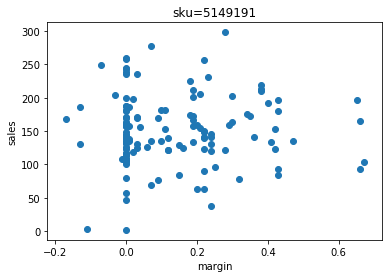

In [17]:
collect_scatter(max_sku, df2)

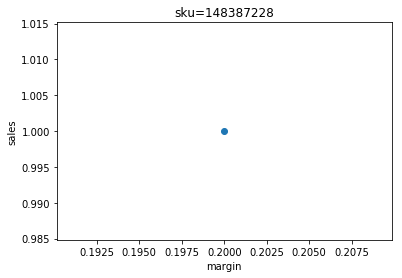

In [18]:
collect_scatter(min_sku, df2)

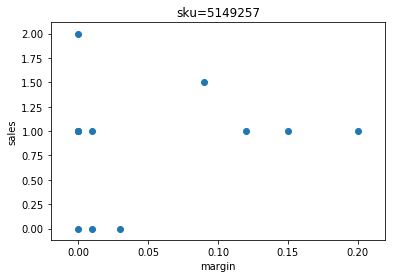

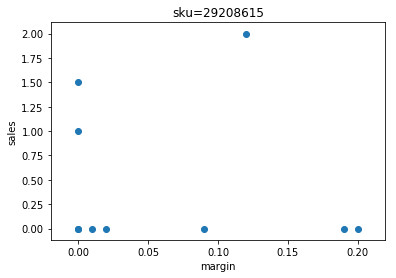

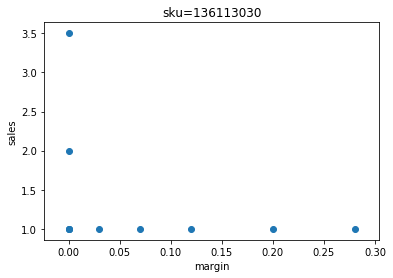

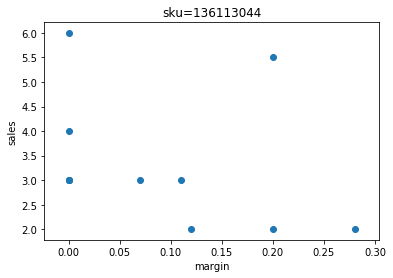

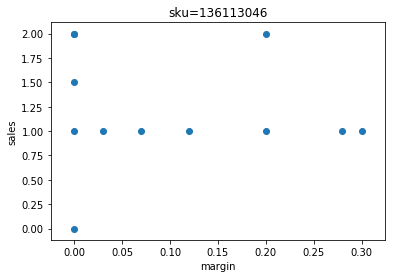

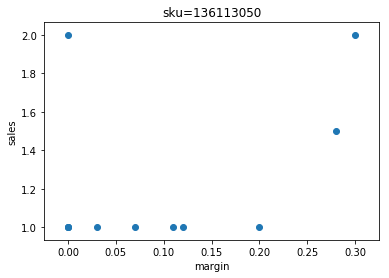

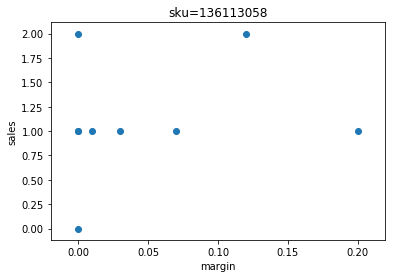

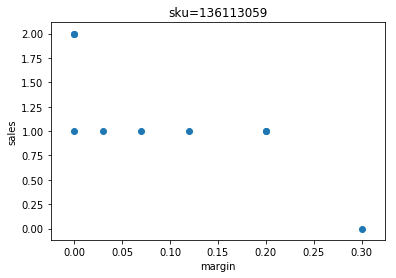

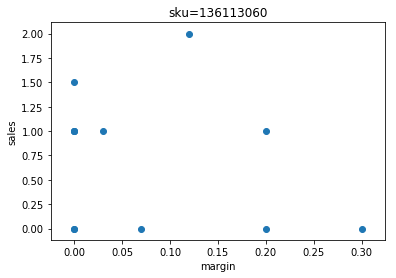

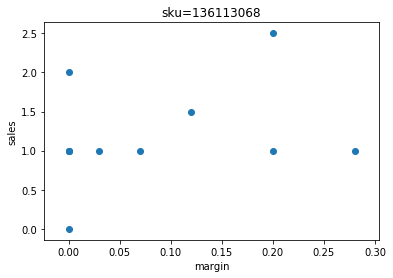

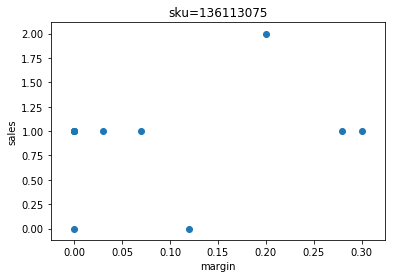

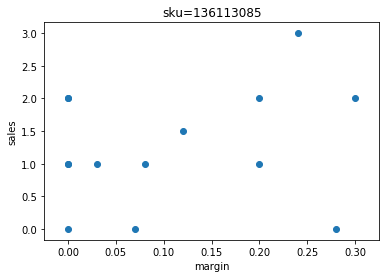

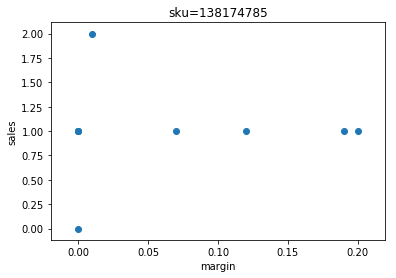

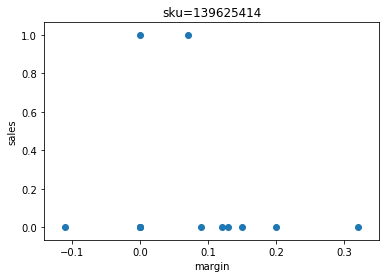

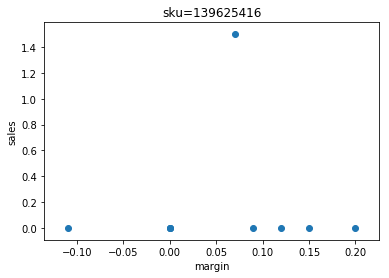

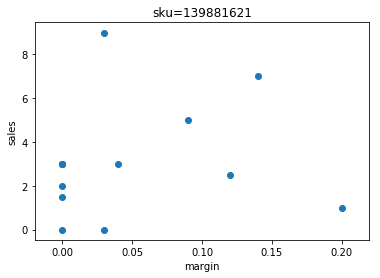

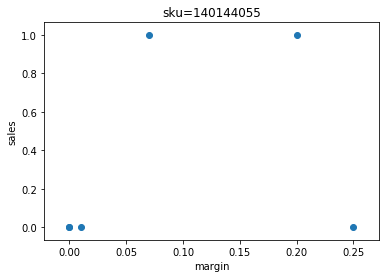

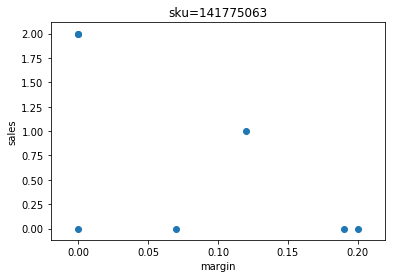

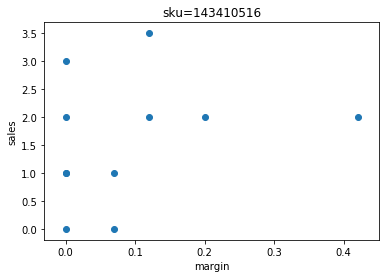

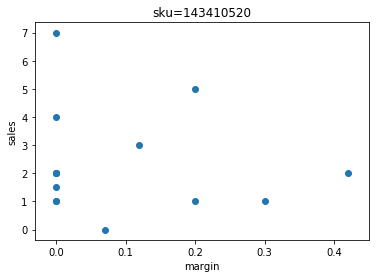

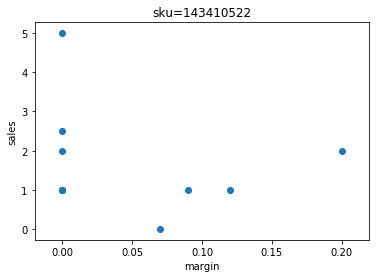

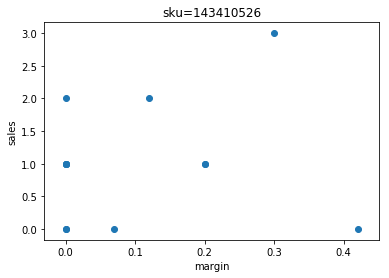

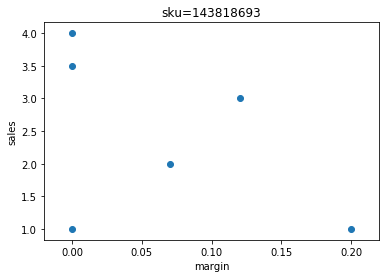

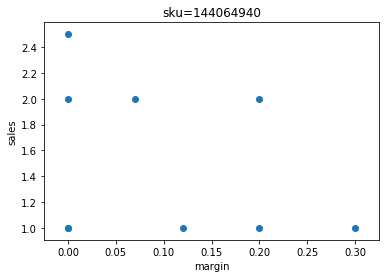

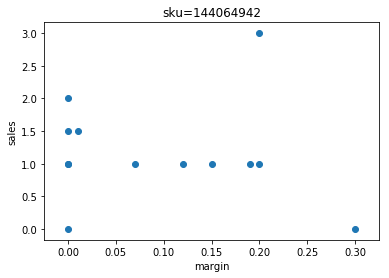

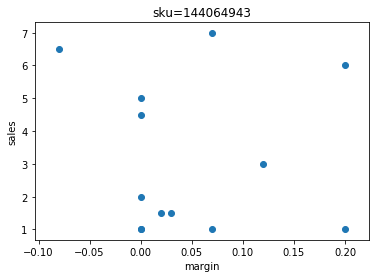

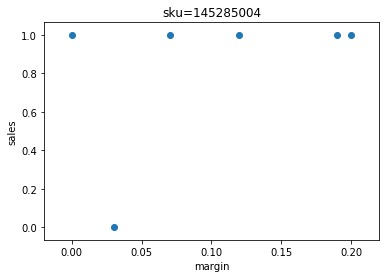

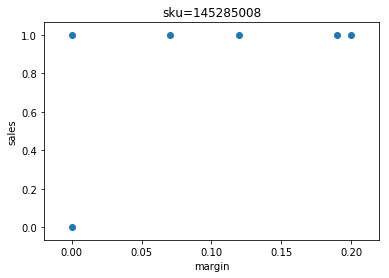

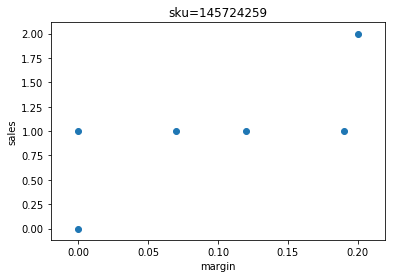

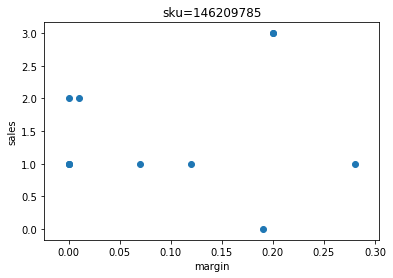

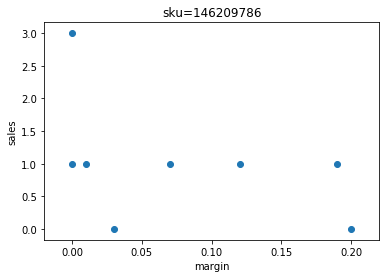

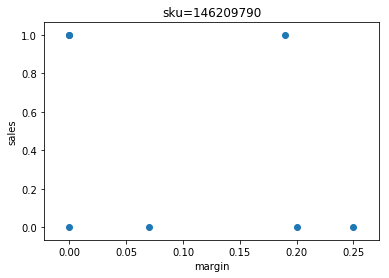

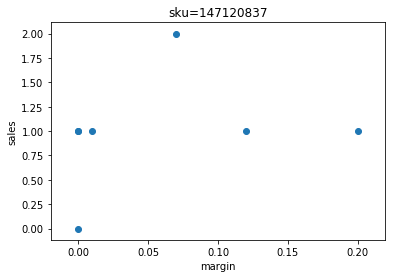

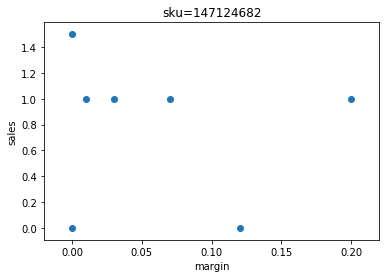

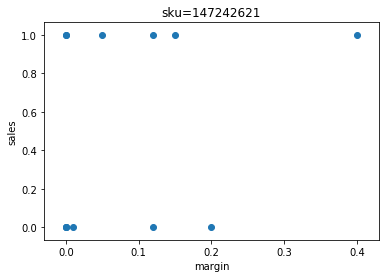

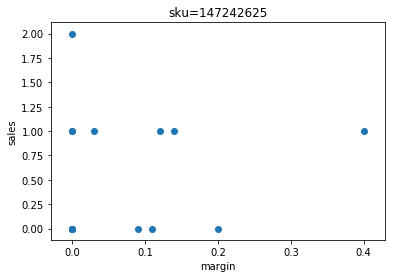

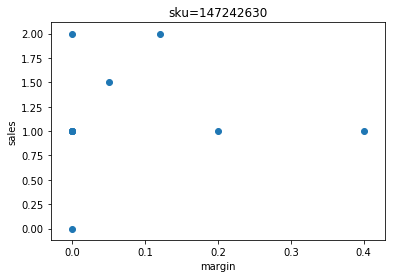

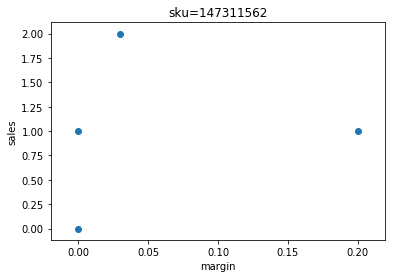

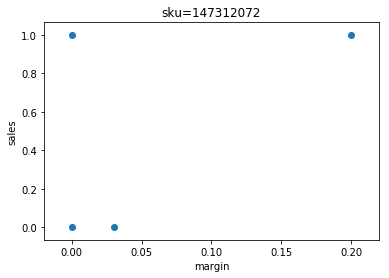

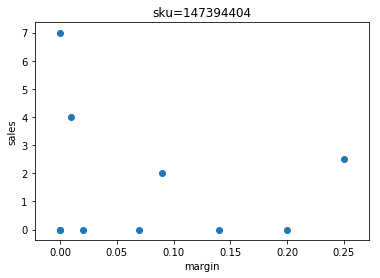

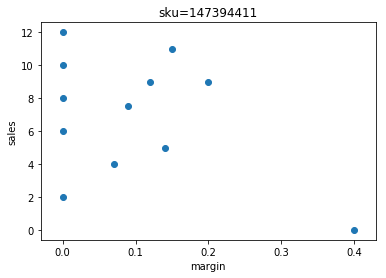

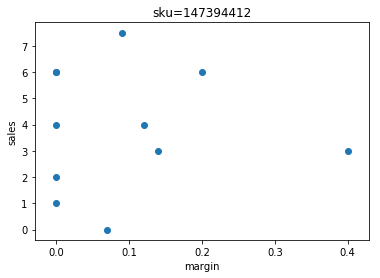

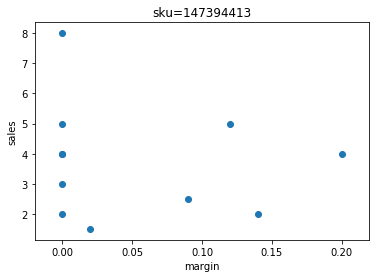

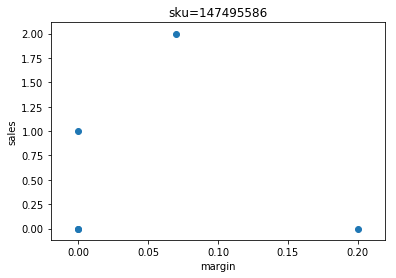

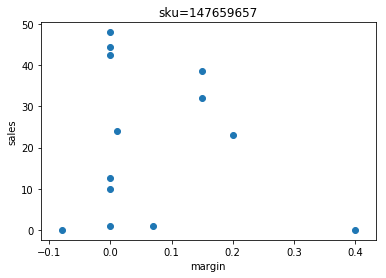

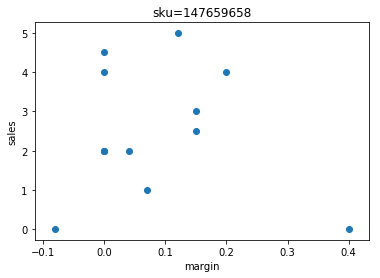

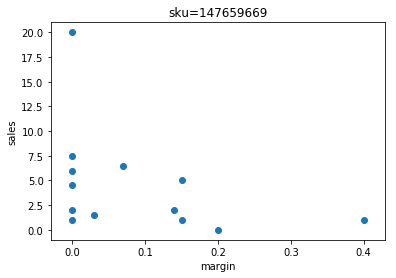

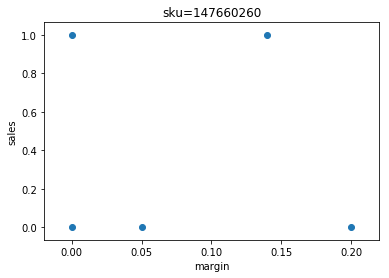

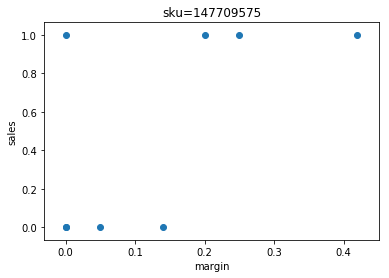

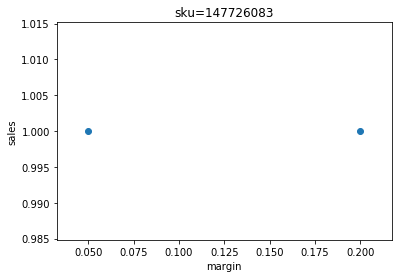

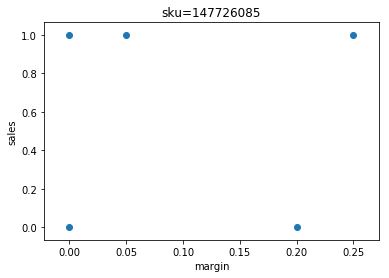

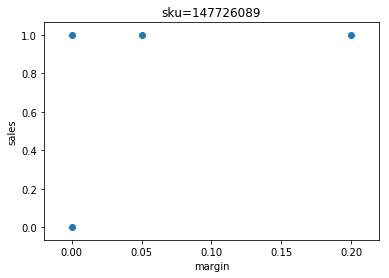

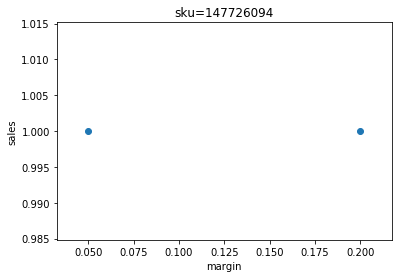

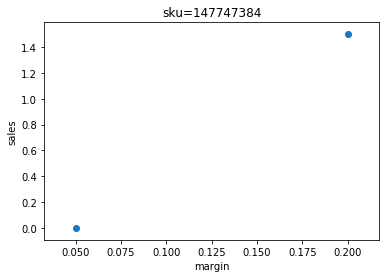

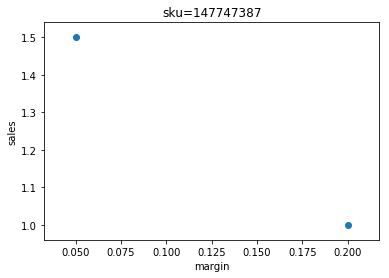

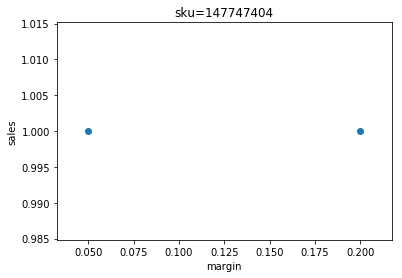

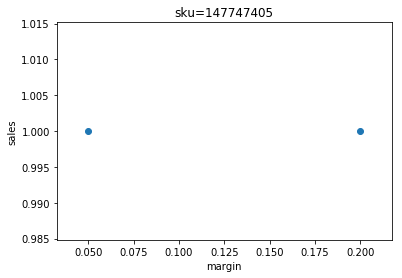

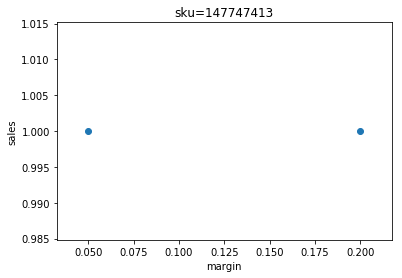

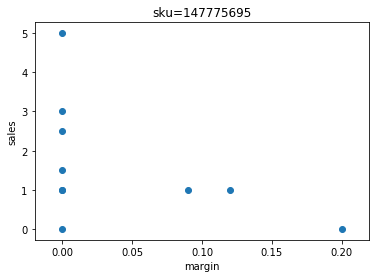

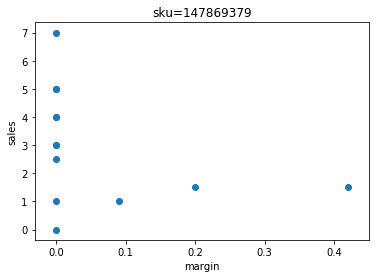

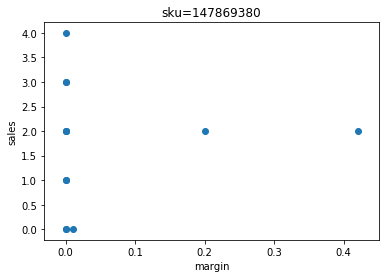

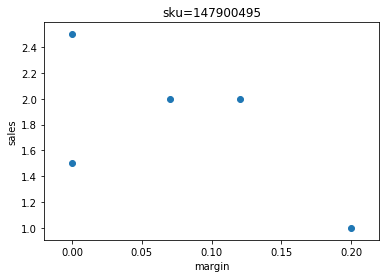

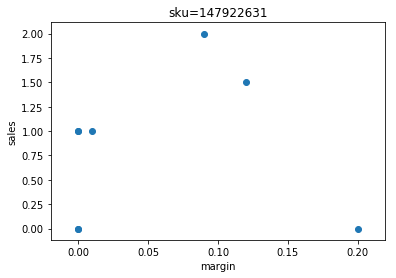

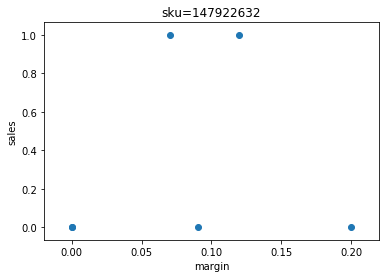

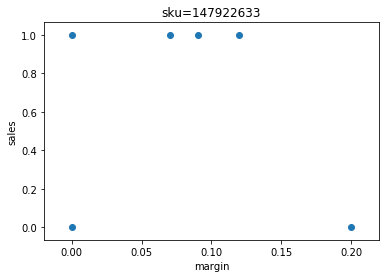

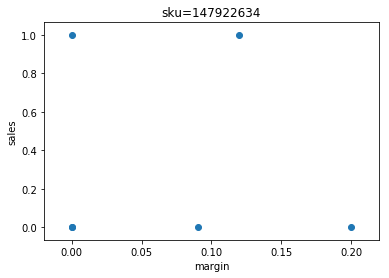

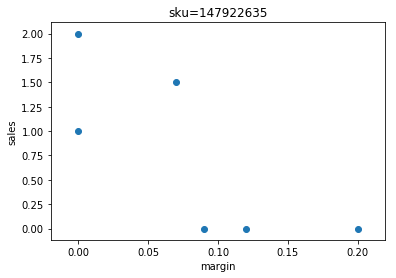

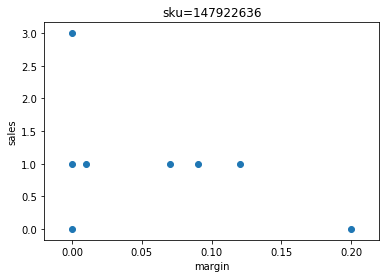

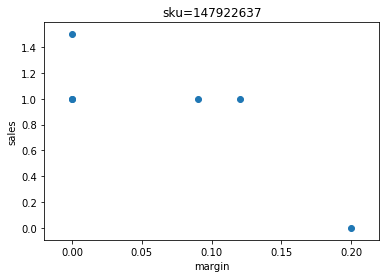

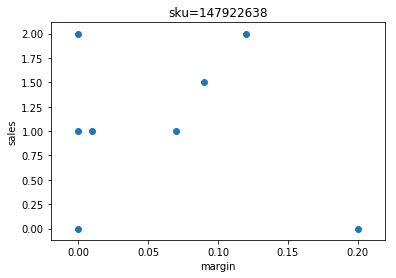

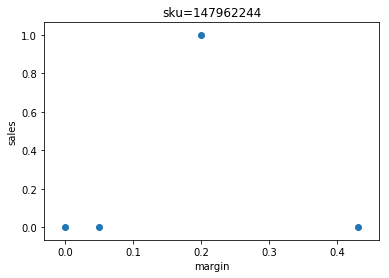

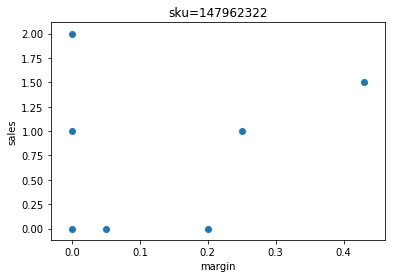

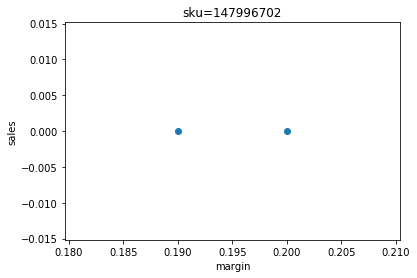

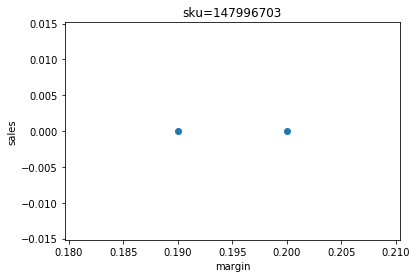

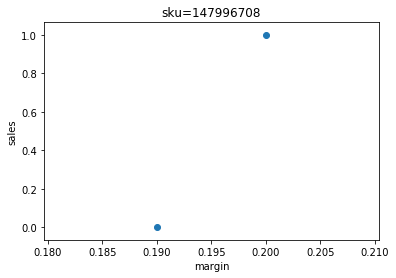

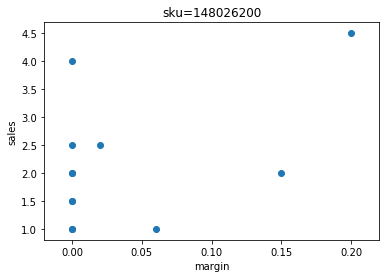

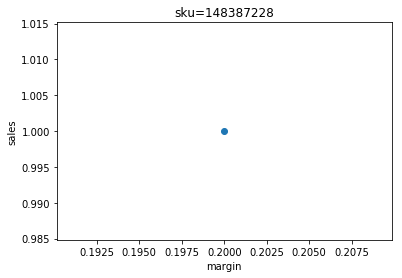

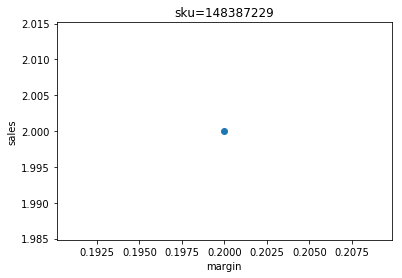

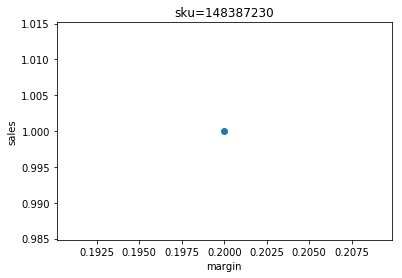

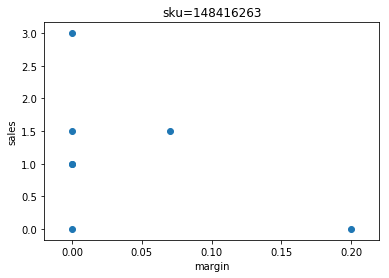

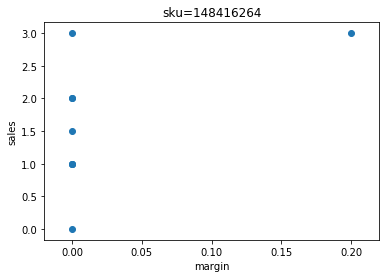

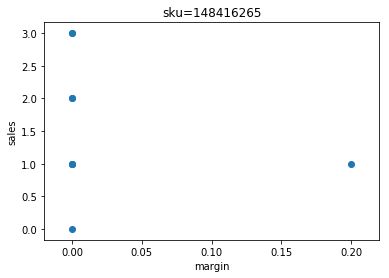

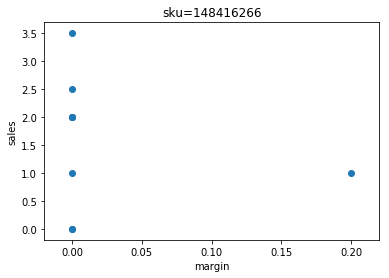

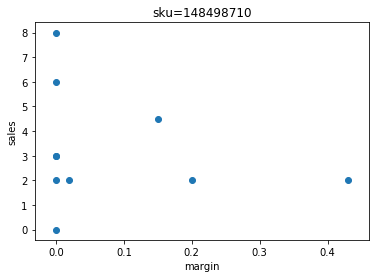

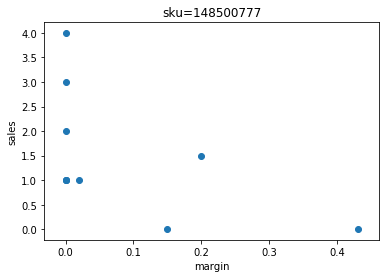

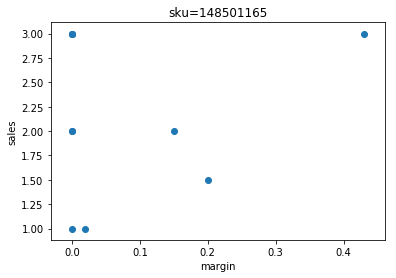

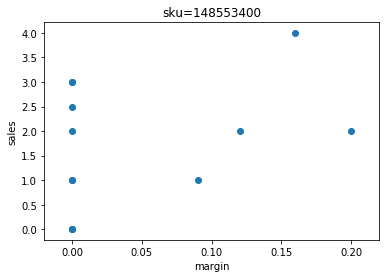

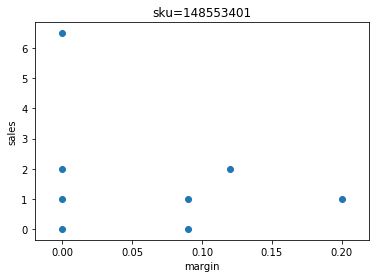

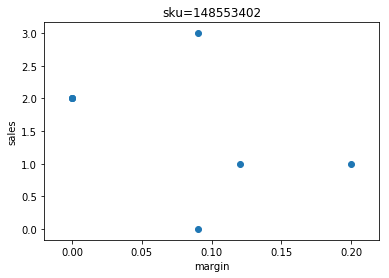

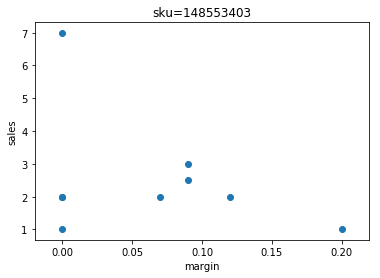

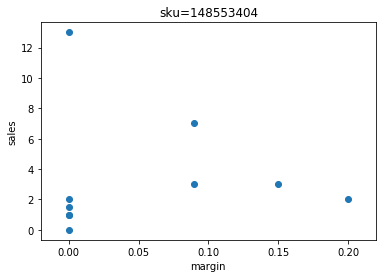

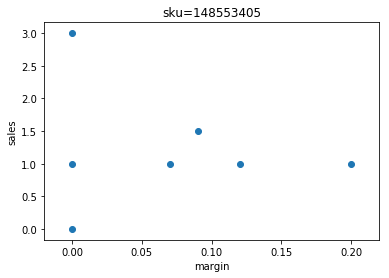

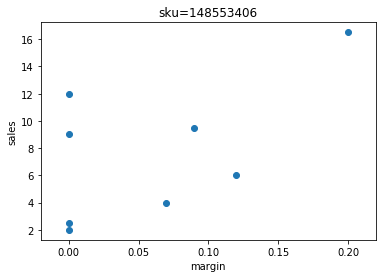

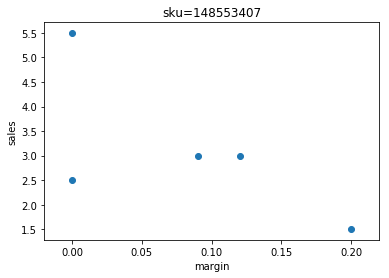

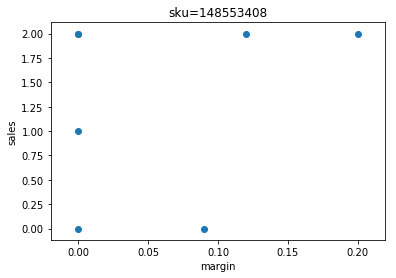

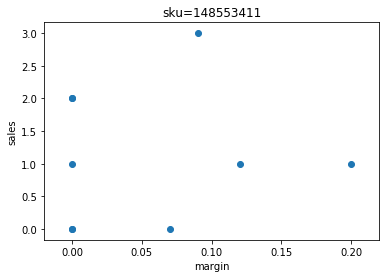

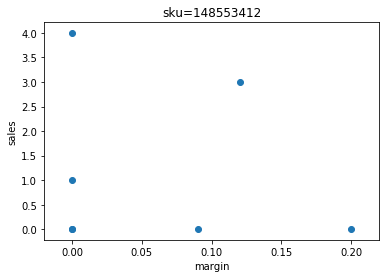

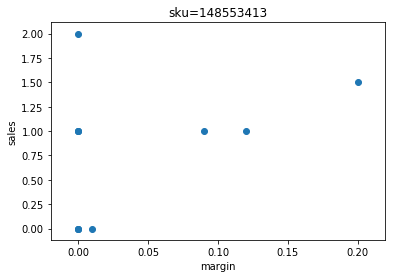

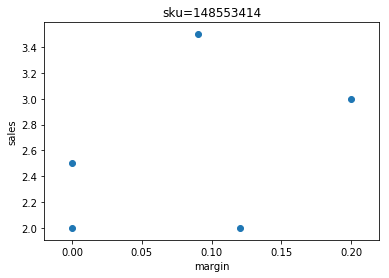

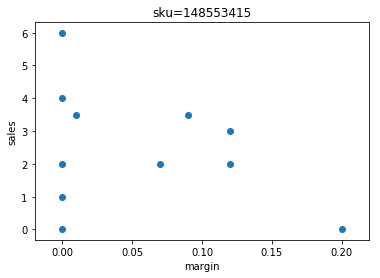

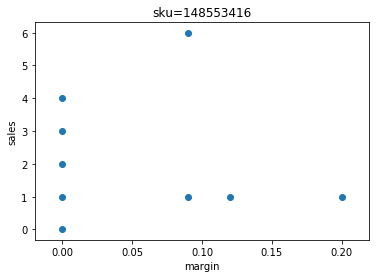

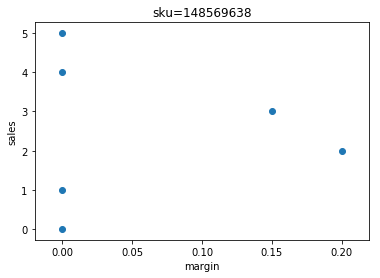

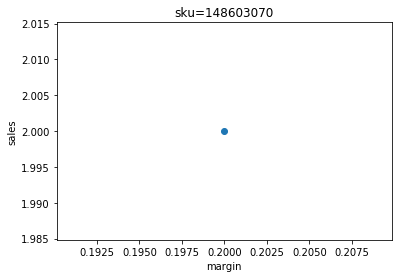

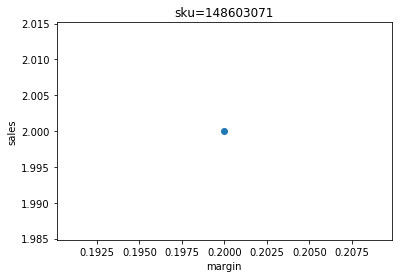

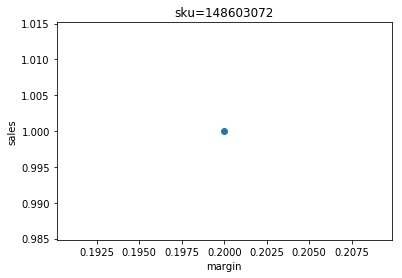

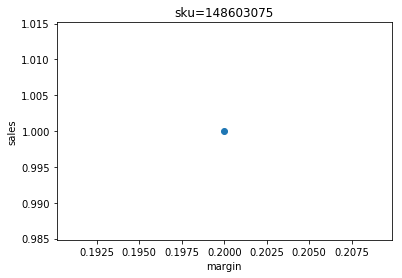

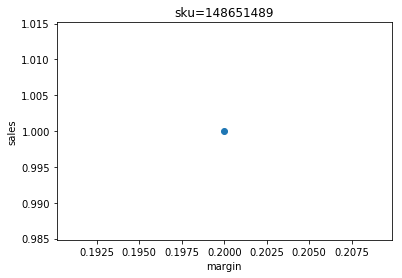

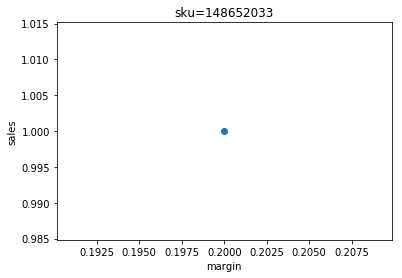

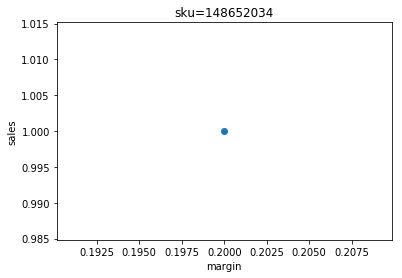

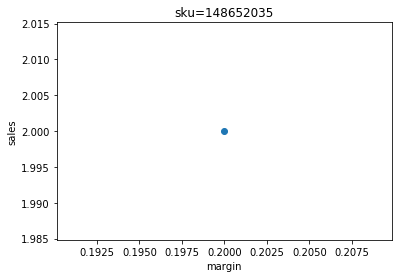

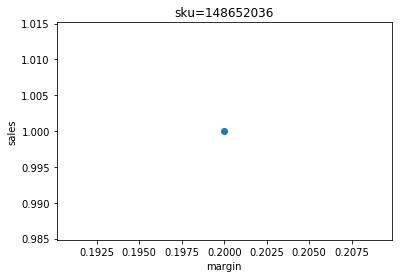

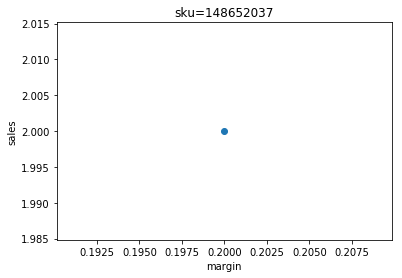

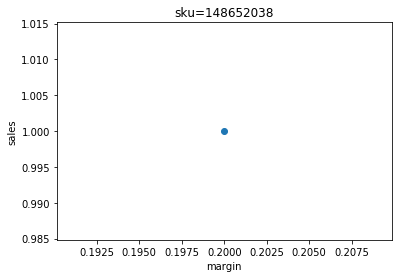

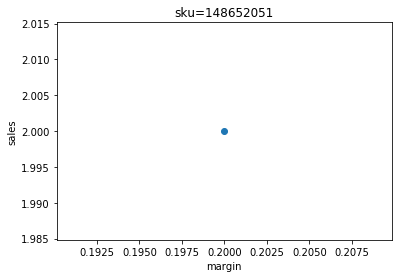

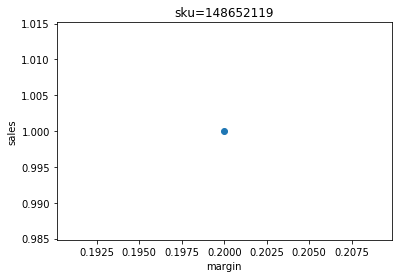

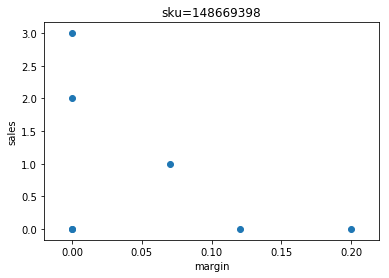

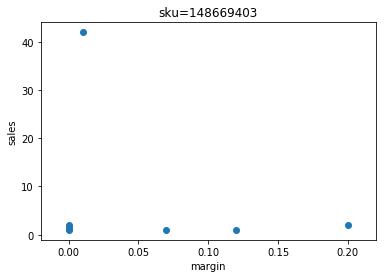

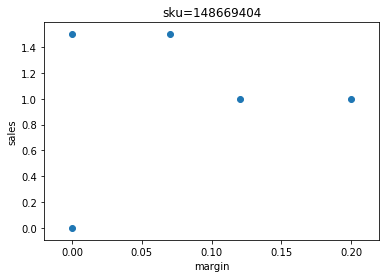

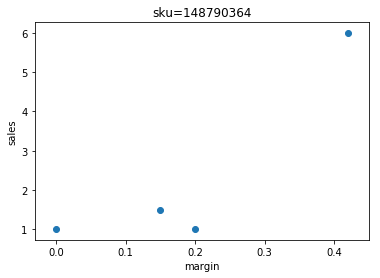

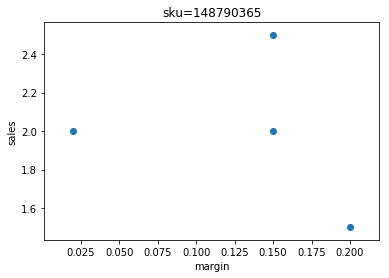

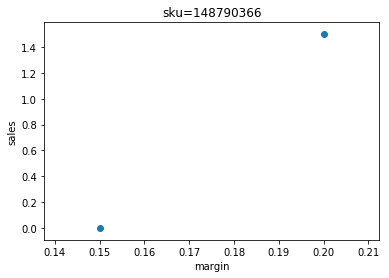

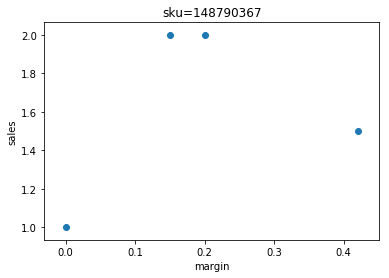

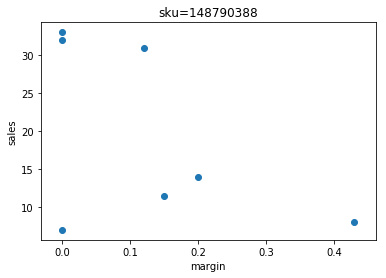

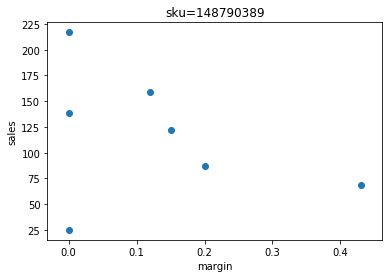

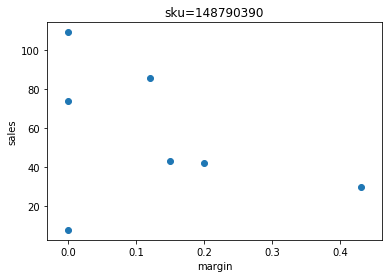

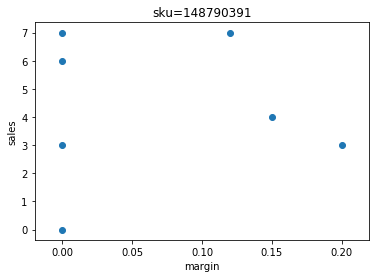

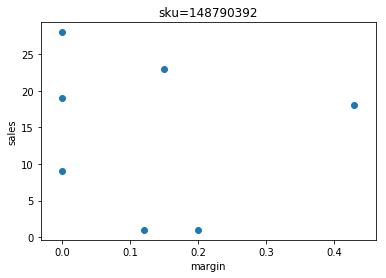

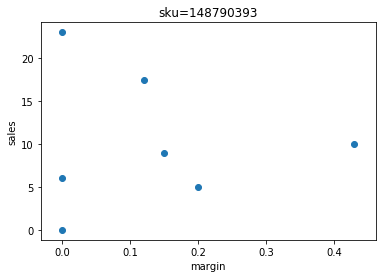

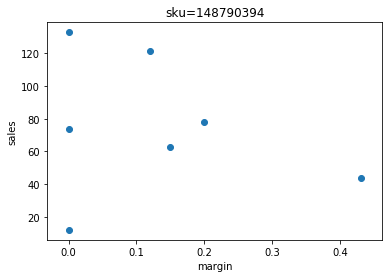

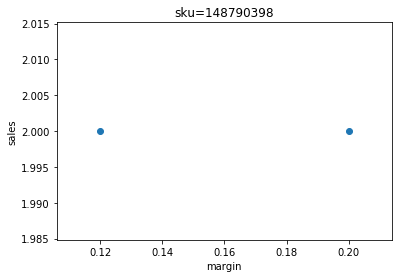

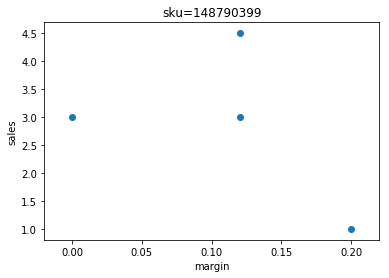

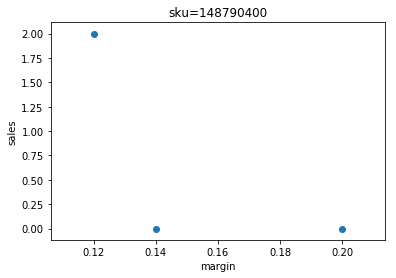

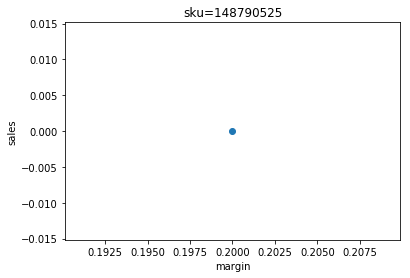

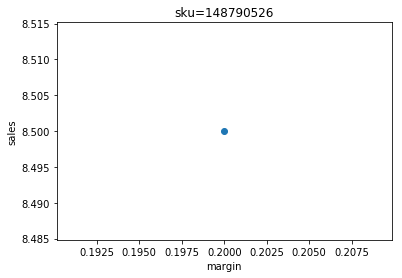

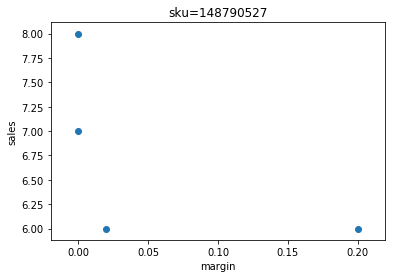

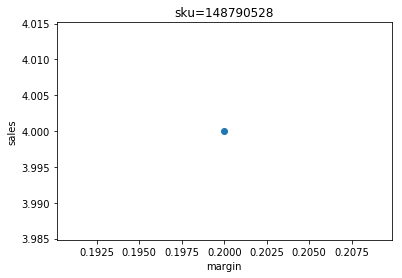

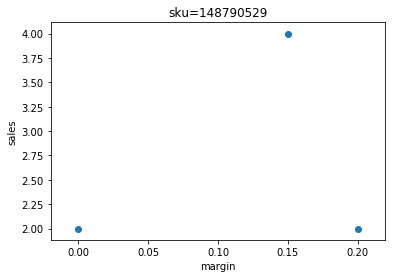

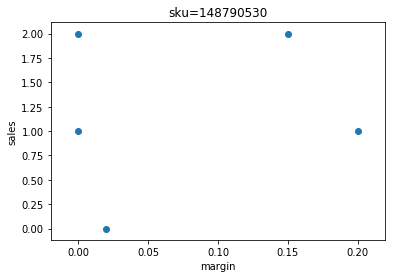

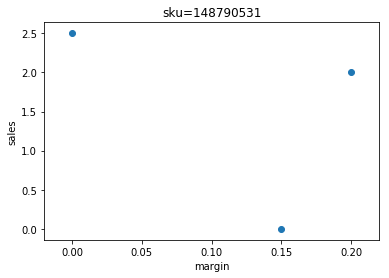

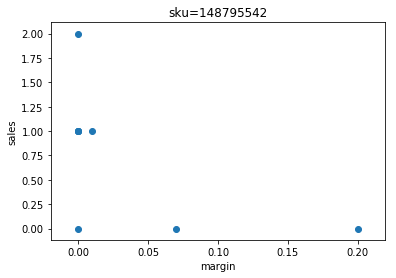

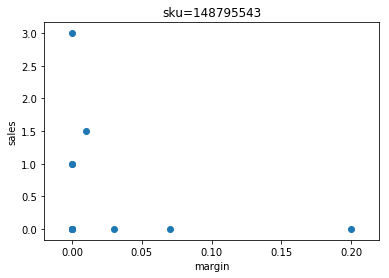

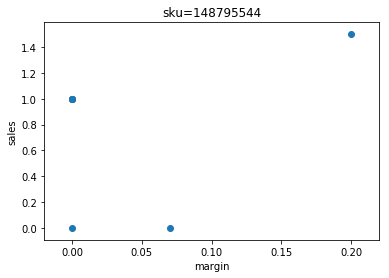

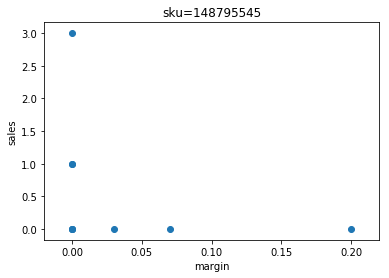

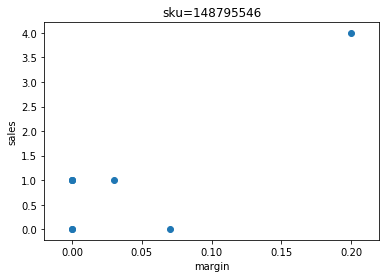

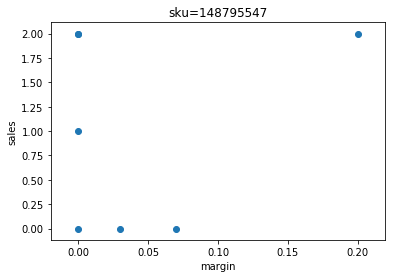

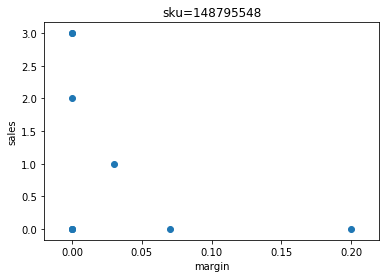

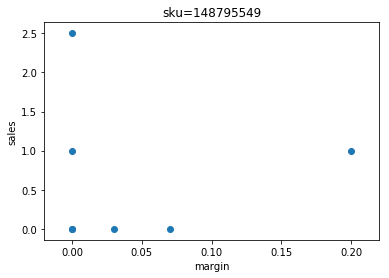

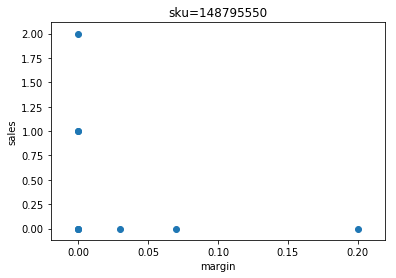

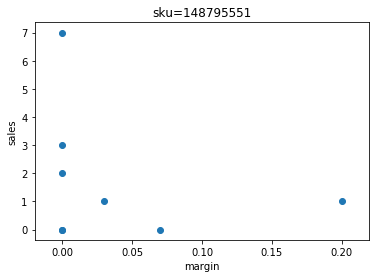

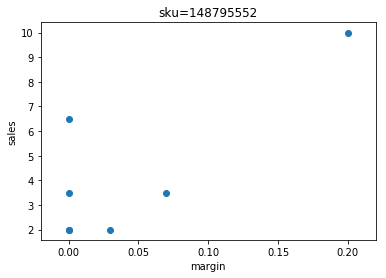

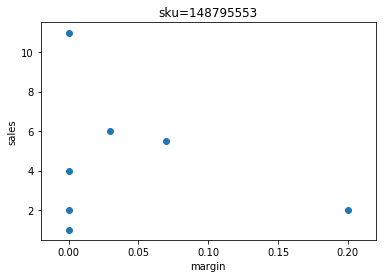

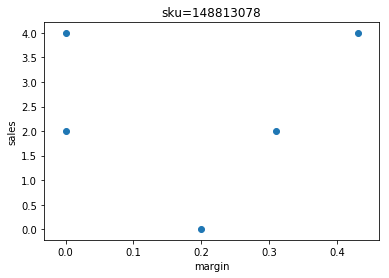

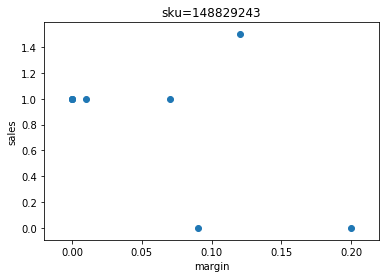

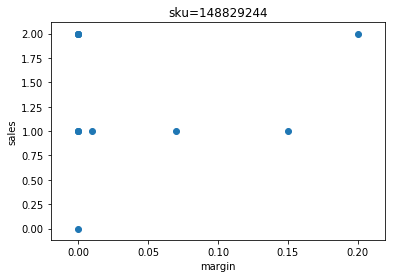

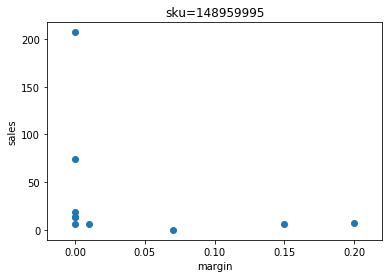

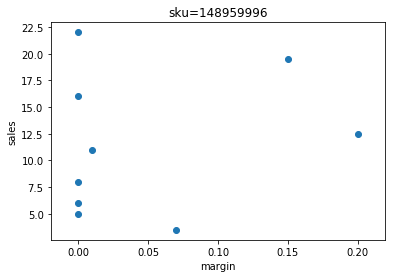

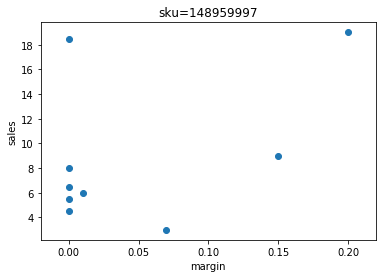

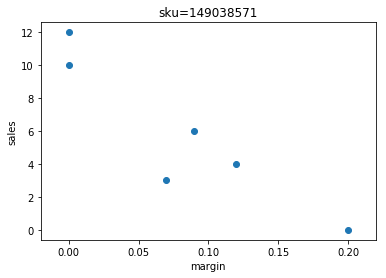

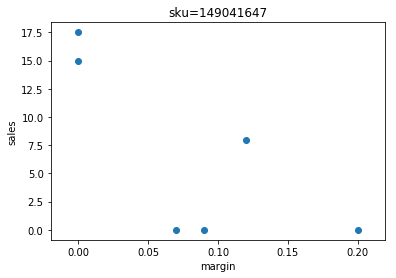

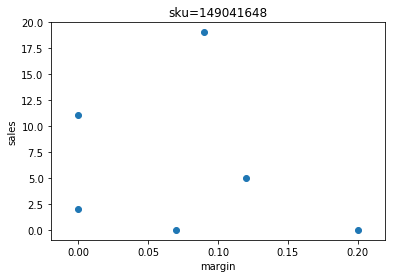

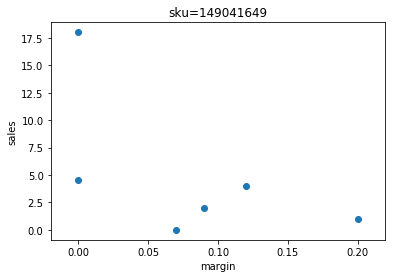

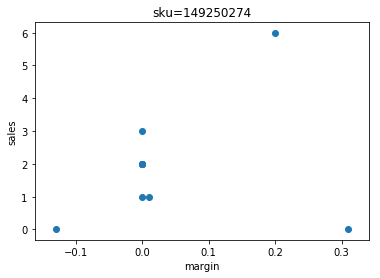

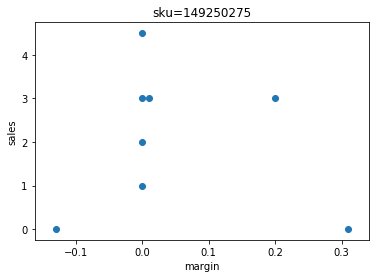

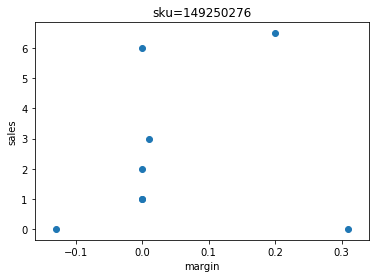

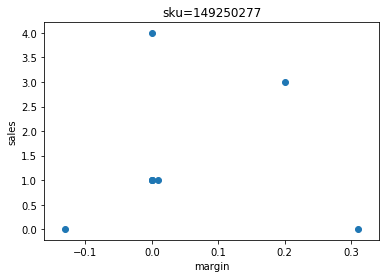

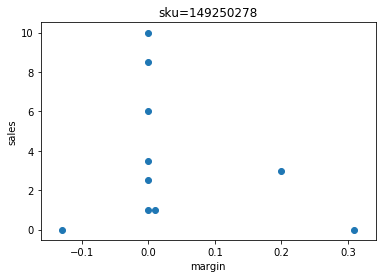

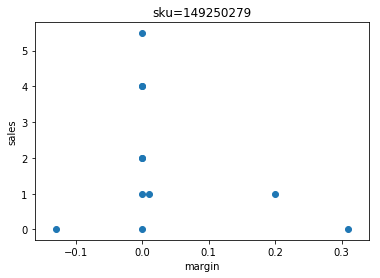

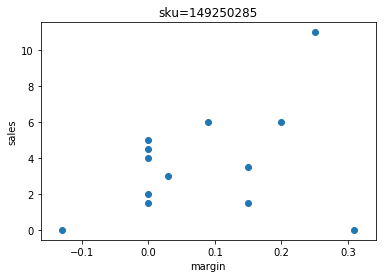

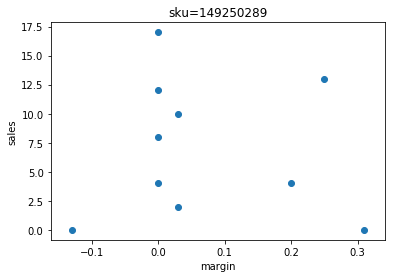

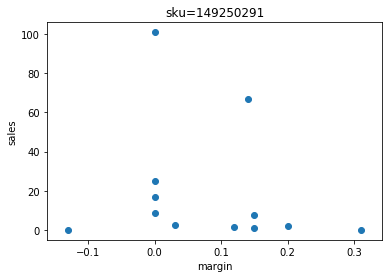

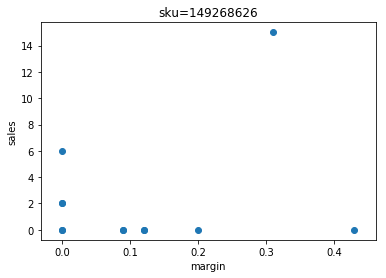

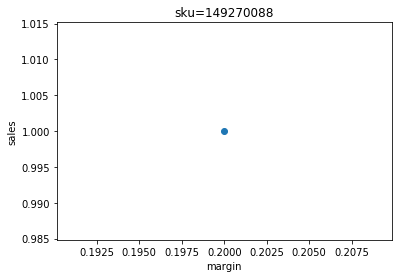

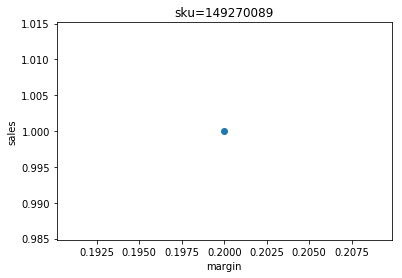

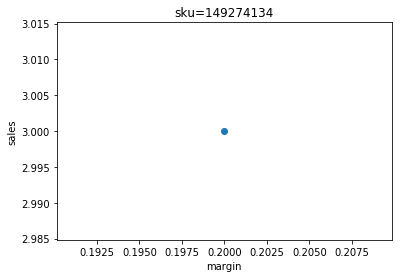

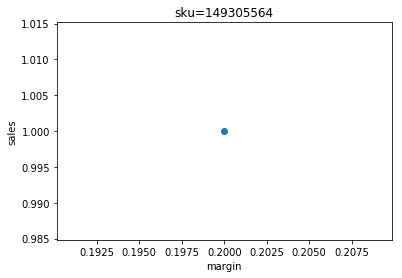

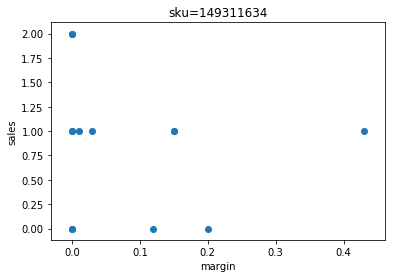

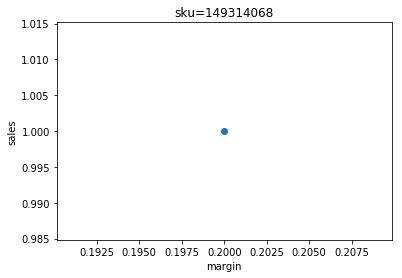

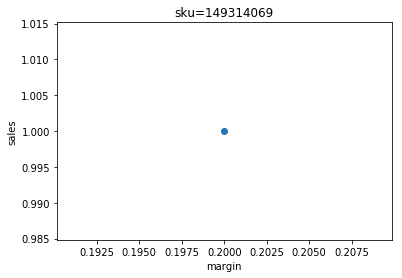

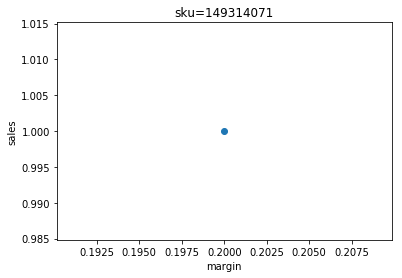

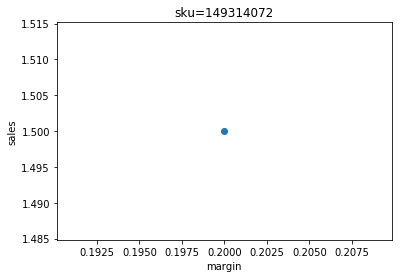

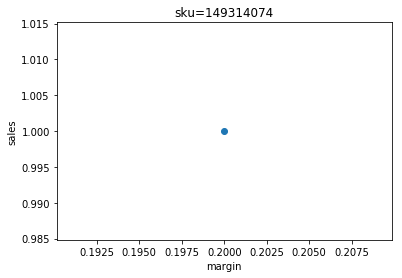

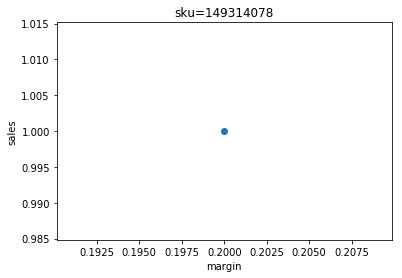

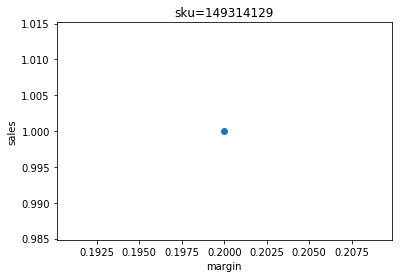

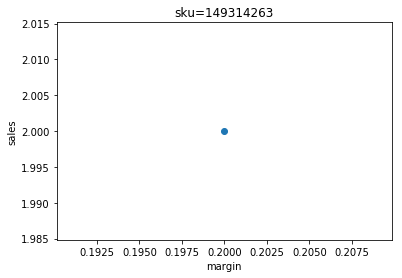

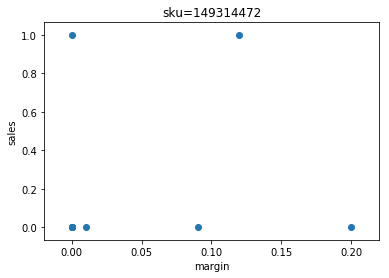

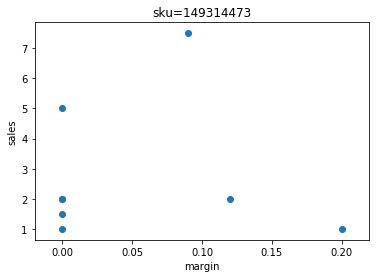

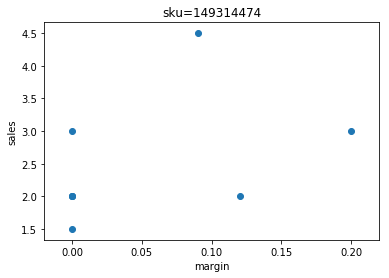

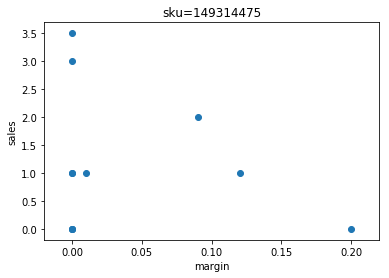

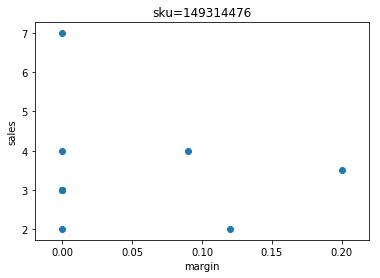

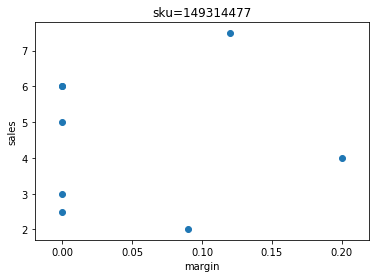

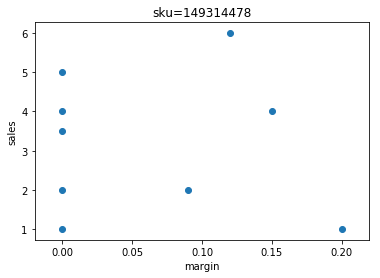

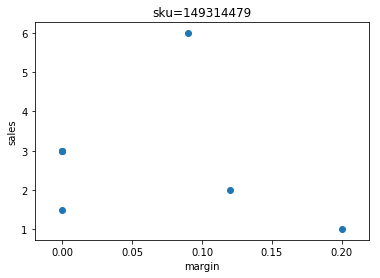

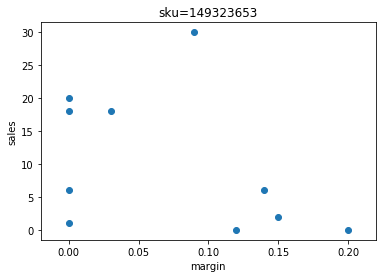

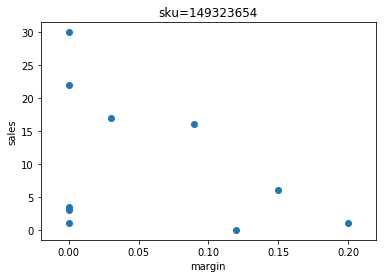

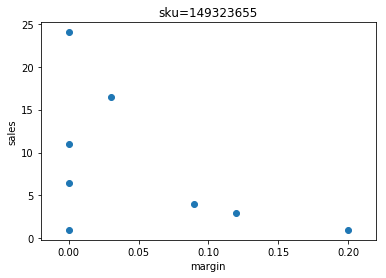

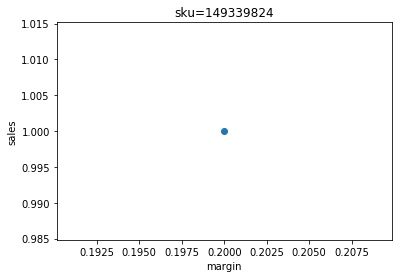

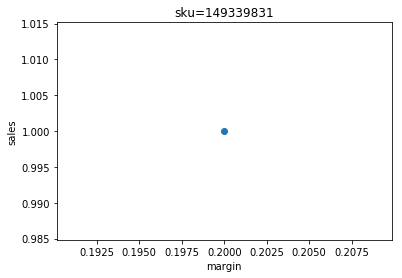

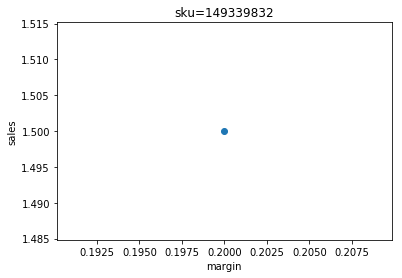

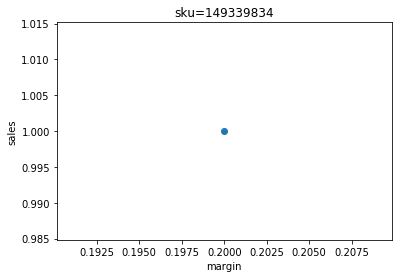

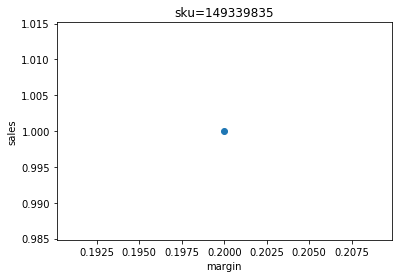

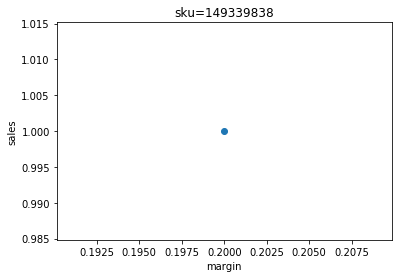

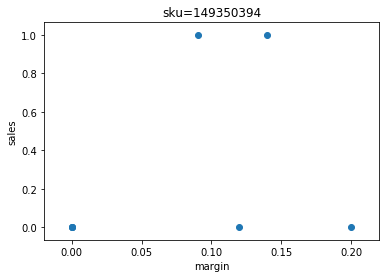

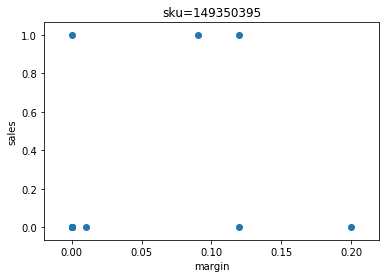

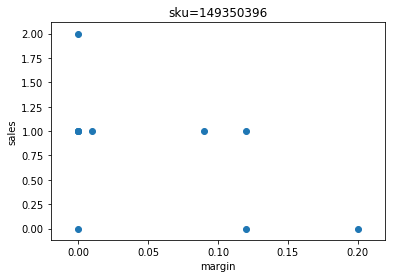

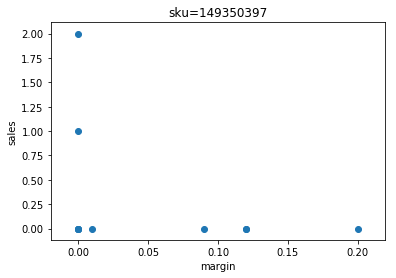

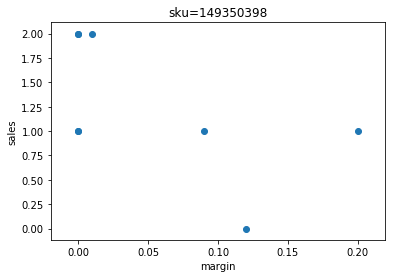

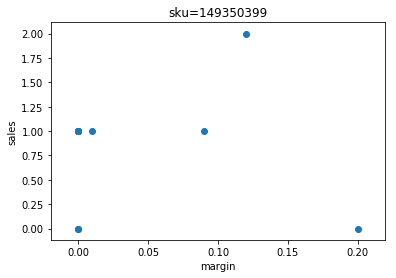

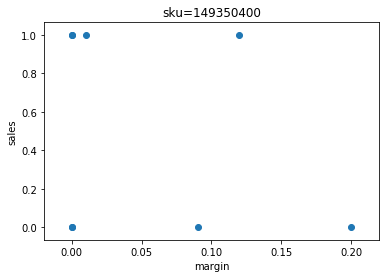

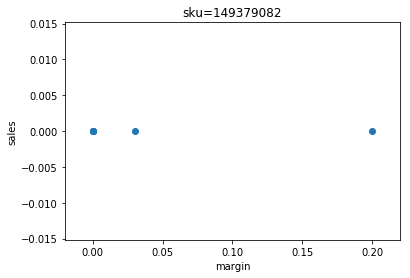

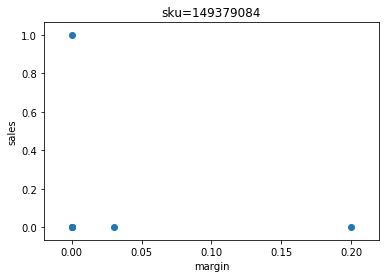

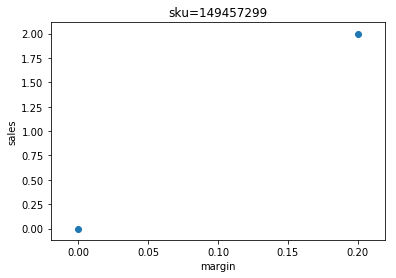

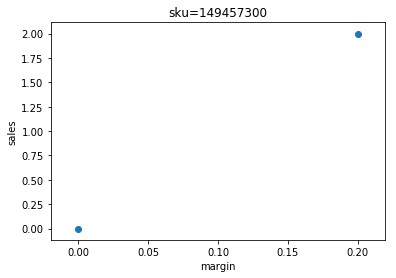

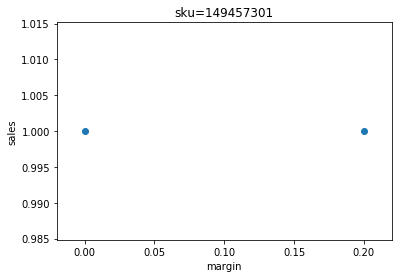

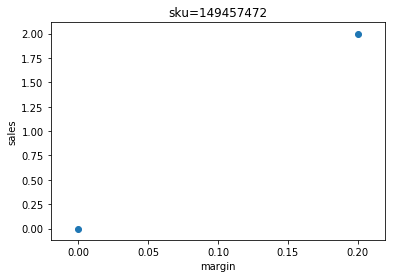

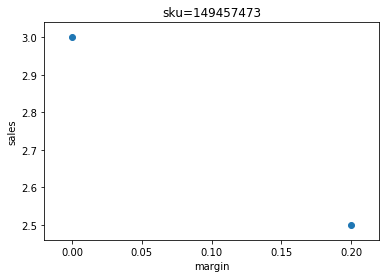

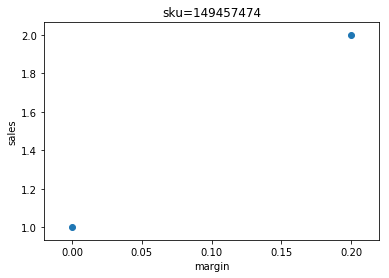

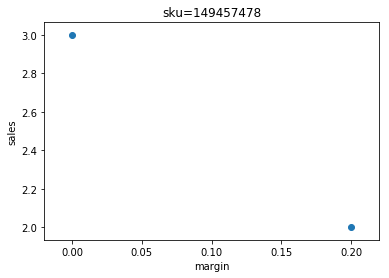

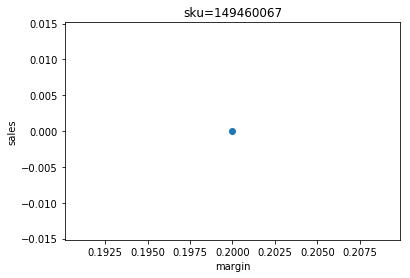

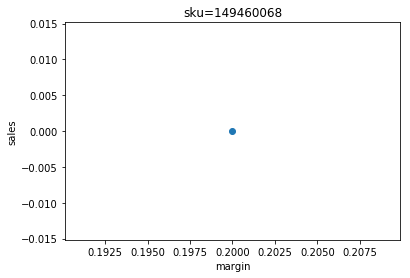

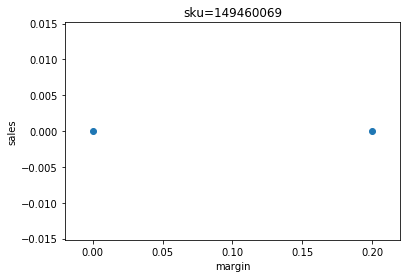

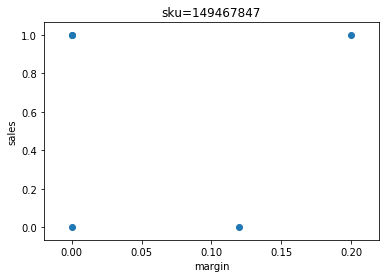

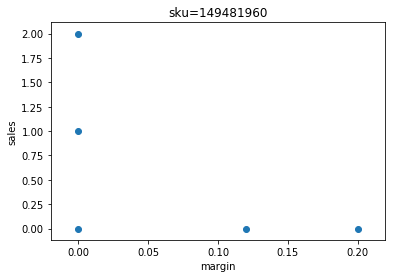

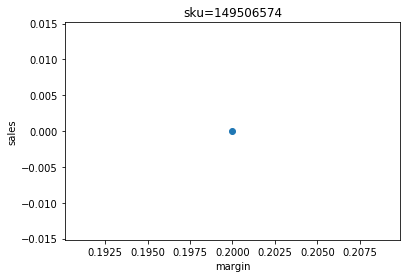

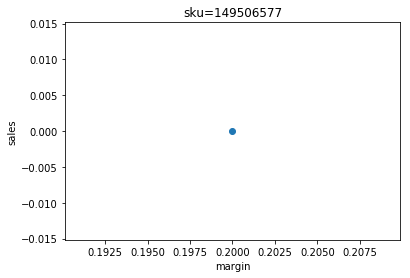

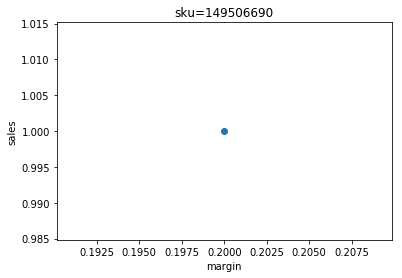

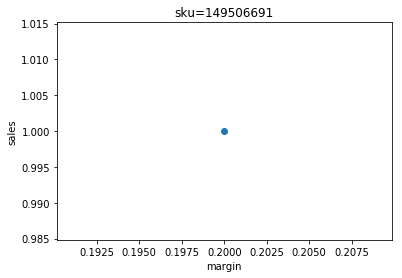

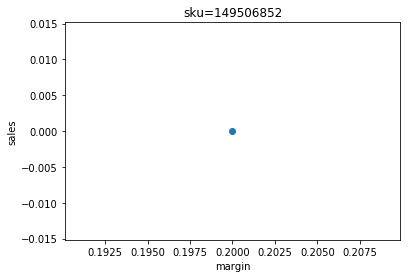

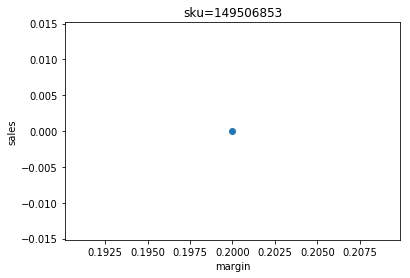

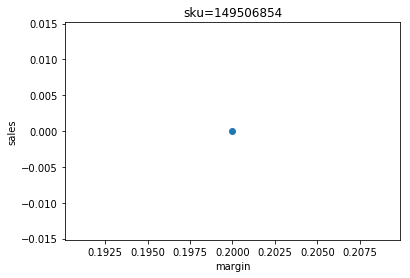

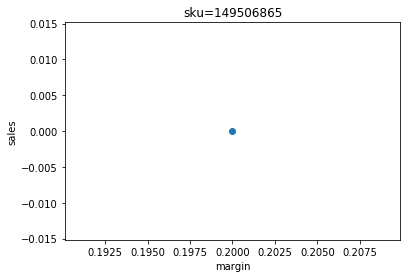

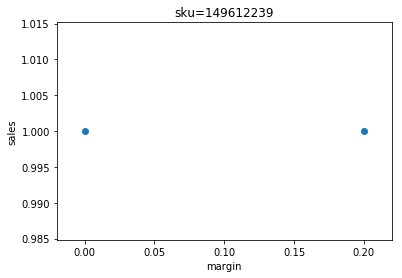

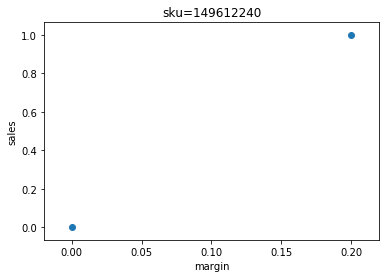

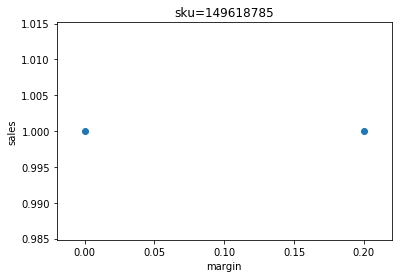

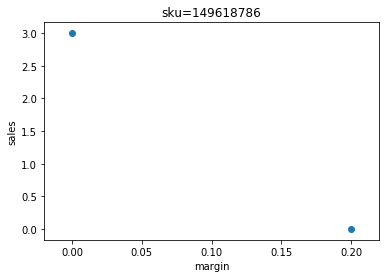

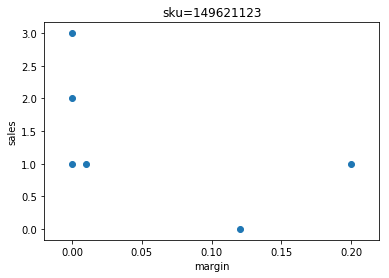

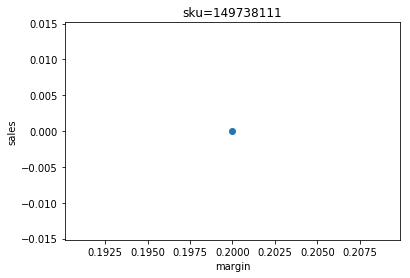

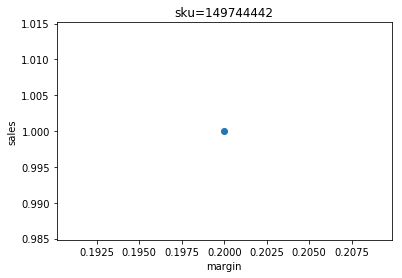

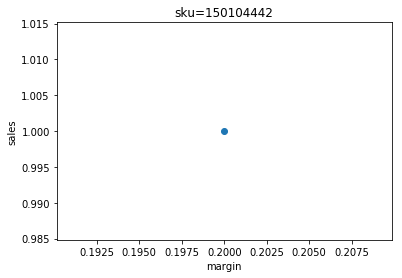

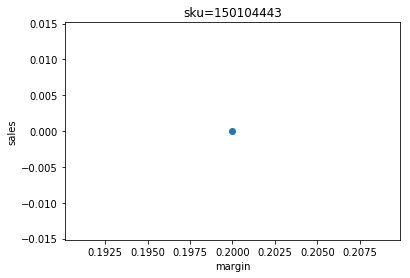

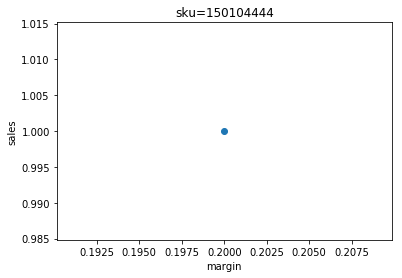

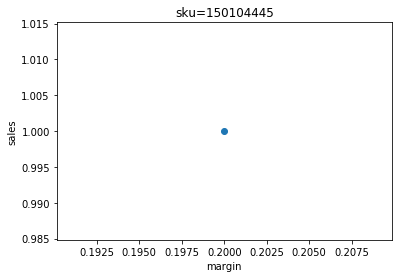

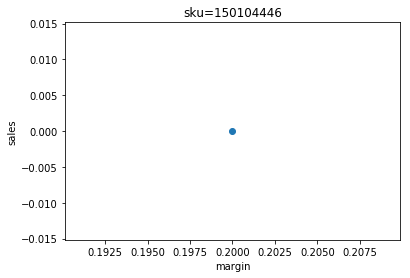

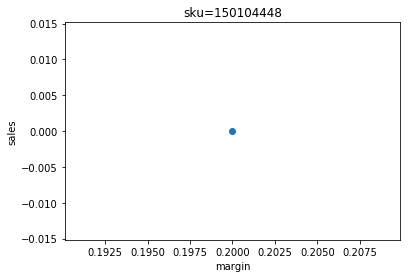

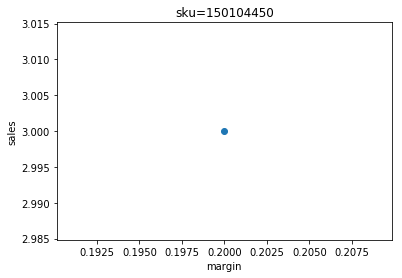

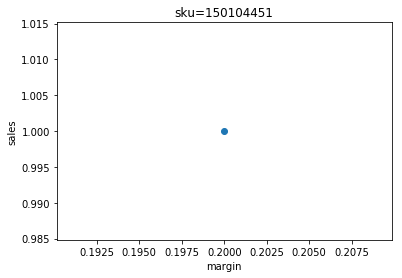

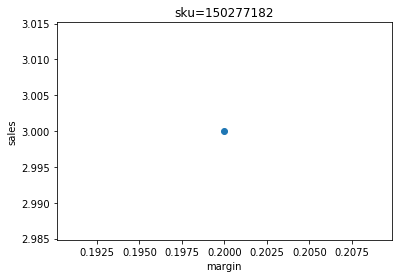

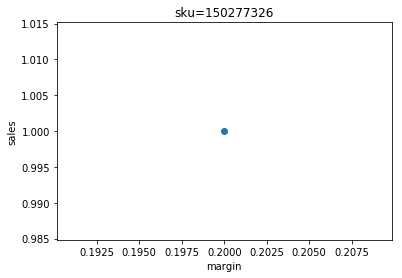

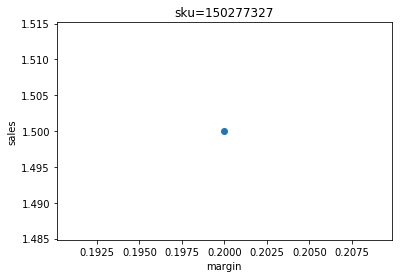

In [19]:
for rare_sku in rare_skus:
    collect_scatter(rare_sku, df2)
    #pr, s = collect_sales_procents(rare_sku, df2)
    #scatter_procents_sales(rare_sku, pr, s)

In [20]:
def plot_procents_sales(sku, procents, sales):
    d = dict((key, value) for (key, value) in zip(procents, sales))
    d = collections.OrderedDict(sorted(d.items()))
    plt.title('sku=' + str(sku))
    plt.plot(d.keys(), d.values())
    plt.xlabel('margin')
    plt.ylabel('sales')
    plt.show()

## Начинаем сглаживать для конкретного SKU
Сначала произведем медиану по оси ординат

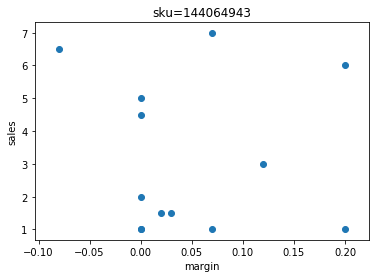

In [21]:
procents, sales = collect_sales_procents(144064943, df2)
scatter_procents_sales(144064943, procents, sales)
#collect_scatter(144064943, df2)
#136113046
#147394412
#144064942

In [22]:
def median_along_ordinate(sku, procents, sales):
    d = dict((key, value) for (key, value) in zip(procents, sales))
    d = collections.OrderedDict(sorted(d.items()))
    l_k = [list(d.keys())[0]]
    l_v = [list(d.values())[0]]
    d_new = {}
    for i, k in enumerate(list(d.keys())[1:]):
        if k - list(d.keys())[0] <= 0.005:
            l_v.append(d[k])
        else:
            if (len(l_k) > 0):
                mean_k = mean(l_k)
                med_v = median(l_v)
                l_k = []
                l_v = []
                d_new[mean_k] = med_v
            else:
                d_new[k] = d[k]
    if len(d_new) == 0:
        d_new[d.keys[0]] = d.values[0]
    return list(d_new.keys()), list(d_new.values())

In [23]:
p_new, s_new = median_along_ordinate(144064943, procents, sales)

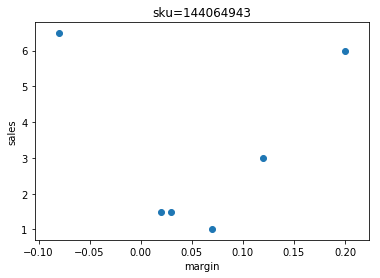

In [24]:
scatter_procents_sales(144064943, p_new, s_new)

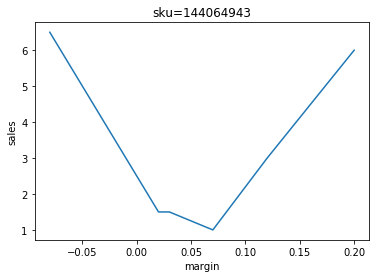

In [25]:
plot_procents_sales(144064943, p_new, s_new)

Теперь будем восстанавливать изменения продаж в пустых промежутках маржи

In [26]:
%%time

#для всех остальных sku собираем sales и prcents
def collect_d_procents_sales(df):
    skus = pd.unique(df['SKU'])
    d_procents_sales = {}
    for sku in skus:
        p, s = collect_sales_procents(sku, df)
        d_procents_sales[sku] = [p, s]
    return d_procents_sales

d_procents_sales = collect_d_procents_sales(df2)

CPU times: user 11.3 s, sys: 54.9 ms, total: 11.4 s
Wall time: 11.4 s


In [27]:
def flatten_along_abscissa(sku, procents, sales, d_procents_sales, frequent_skus):
    #skus = pd.unique(df2['SKU'])
    #skus = np.delete(skus, np.where(skus == sku)[0])
    skus = frequent_skus
    
    d = dict((key, value) for (key, value) in zip(procents, sales))
    d = collections.OrderedDict(sorted(d.items()))
    l_k = [list(d.keys())[0]]
    l_v = [[list(d.keys())[0]]]
    p_new = [list(d.keys())[0]]
    s_new = [list(d.values())[0]]
    #print('d.keys: ', d.keys())#####
    for i, k in enumerate(list(d.keys())[1:]):
        #print('key: ', k) #####
        if k - l_k[0] >= 0.02: ### что вычитать
            #print('flat') ####
            j = 1
            for indent in np.arange(l_k[0], l_k[0] + round(k - l_k[0], 2), 0.01): 
                indent = round(indent, 2)
                indents = []
                for s in skus:
                    if indent in d_procents_sales[s][0]:
                        indices = np.where(d_procents_sales[s][0] == indent)[0] #####
                        for ind in indices:
                            indents.append(d_procents_sales[s][1][ind])
                if len(indents) > 0:
                    l_v.append([])
                    l_v[j] = indents
                    j += 1 # это номер заполняемого indent для каждого из них в l_v собираем по всем sku
                    l_k.append(indent)
        if len(l_k) == 0:
            p_new.append(k)
            s_new.append(d[k])
        else:
            for lk in l_k:
                p_new.append(lk)
            for li in l_v:
                s_new.append(median(li))
        l_k = [k]
        l_v = [[d[k]]]
        p_new.append(k)
        s_new.append(d[k])
     
    return p_new, s_new

In [29]:
%%time

p_flat, s_flat = flatten_along_abscissa(144064943, p_new, s_new, d_procents_sales, frequent_skus)

CPU times: user 120 ms, sys: 0 ns, total: 120 ms
Wall time: 119 ms


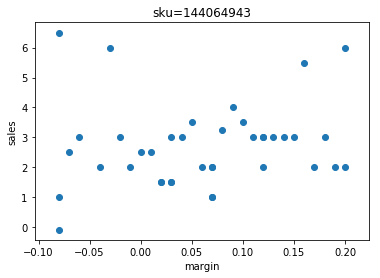

In [30]:
scatter_procents_sales(144064943, p_flat, s_flat)

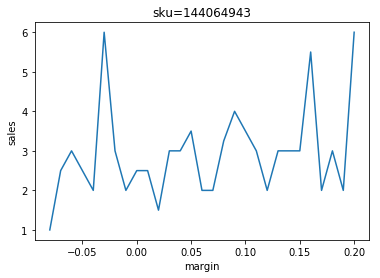

In [31]:
plot_procents_sales(144064943, p_flat, s_flat)

In [748]:
#for i in range(len(p_new)):
#    print(np.where(p_flat == p_new[i])[0])
#    print(np.where(s_flat == s_new[i])[0])
#    print()

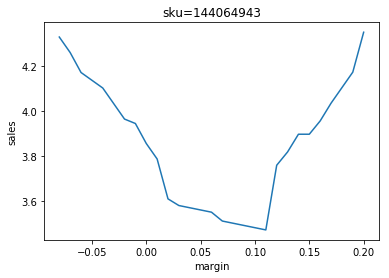

In [41]:
plot_procents_sales(144064943, p_flat, savgol_filter(s_flat, 91, 1, mode='nearest'))

In [33]:
def get_sku_info(sku, df, frequent_skus):
    print('Исходный scatter')
    collect_scatter(sku, df)
    print()
    
    print('Медиана по оси маржи')
    procents, sales = collect_sales_procents(sku, df)
    p_new, s_new = median_along_ordinate(sku, procents, sales)
    scatter_procents_sales(sku, p_new, s_new)
    plot_procents_sales(sku, p_new, s_new)
    print()
    
    d_procents_sales = collect_d_procents_sales(df)

    print('Восстановление промежутков по категориям')
    p_flat, s_flat = flatten_along_abscissa(sku, p_new, s_new, d_procents_sales, frequent_skus)
    scatter_procents_sales(sku, p_flat, s_flat)
    plot_procents_sales(sku, p_flat, s_flat)
    print()
    
    print('Сглаженный восстановленный по категориям')
    plot_procents_sales(sku, p_flat, savgol_filter(s_flat, 91, 1, mode='nearest'))

Исходный scatter


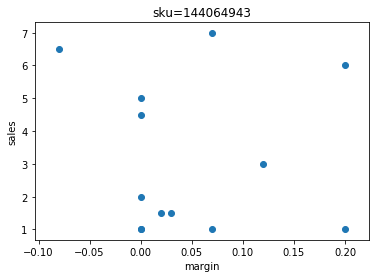


Медиана по оси маржи


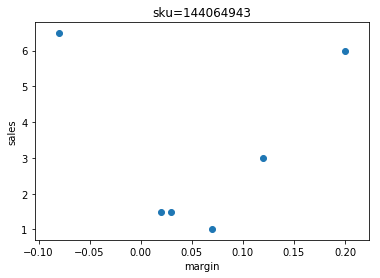

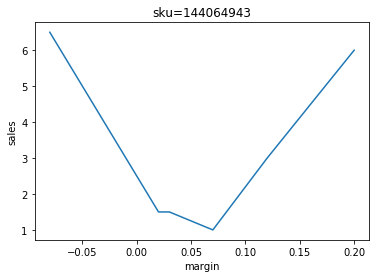


Восстановление промежутков по категориям


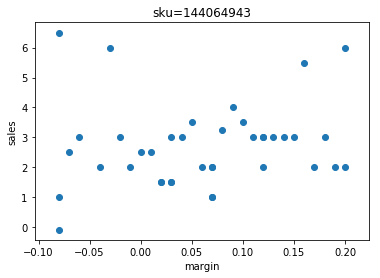

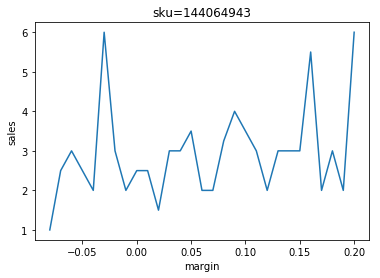


Сглаженный восстановленный по категориям


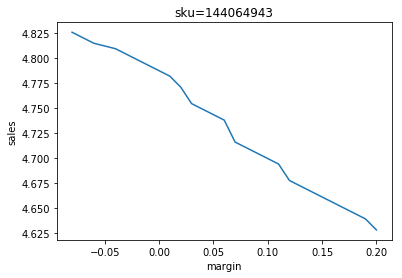

In [34]:
get_sku_info(144064943, df2, frequent_skus)